# Package importing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from tqdm import tqdm, trange
from copy import deepcopy

from statsmodels.api import OLS
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

import torch
from torch.nn import functional as F
device = torch.device('cuda:0')
torch.set_default_device(device.type+':'+str(device.index))

from torchquad import set_up_backend  # Necessary to enable GPU support
from torchquad import  Simpson# The available integrators
from torchquad.utils.set_precision import set_precision
import torchquad

from functorch import  jacfwd, hessian as ft_hessian

set_up_backend("torch", data_type="float64")

simp = Simpson()

def integral( f, a, b):
    return simp.integrate(f, dim=1, N=101, integration_domain=[[a, b]])

import gc


/home/hdnguyen/miniconda3/envs/env/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [2]:
import pickle
def open_pickle(name):
    with open('./'+name+'.pickle', 'rb') as f:
         return pickle.load(f)

def save_pickle(name,data):
    with open('./'+name+'.pickle', 'wb') as f:
        pickle.dump(data, f)

We define manually the number of parameters and their names as per the CVA experiment in the paper.

In [3]:
risk_horizons =[0.01, 0.1, 1]

num_para = 103
num_diff = 28
num_rates = 10
num_spreads = 9
group = dict()
group[0] = np.arange(num_rates) # initial interest rate
group[1] = np.arange(num_rates, 2*num_rates-1) # initial fx rate
group[2] = np.arange(2*num_rates, 2*num_rates + num_spreads- 1) # initial spread rate
group[3] = np.arange(num_diff, num_diff + num_rates) # speed parameters for interest rate
group[4] = np.arange(num_diff+ num_rates, num_diff + 2*num_rates) # longterm mean  for interest rate
group[5] = np.arange(num_diff+ 2*num_rates, num_diff + 3*num_rates) # vol for interest rate
group[6] = np.arange(num_diff+ 3*num_rates, num_diff + 4*num_rates-1)  # vol for fx rate
group[7] = np.arange(num_diff+ 5*num_rates-1, num_diff+ 5*num_rates-1+num_spreads-1)  # speed parameters for spread rate 
group[8] = np.arange(num_diff+ 5*num_rates-1+num_spreads, num_diff+ 5*num_rates-1+2*num_spreads-1) # longterm mean  for spread rate
group[9] = np.arange(num_diff+ 5*num_rates-1+2*num_spreads, num_diff+ 5*num_rates-1+3*num_spreads-1) # vol for spread rate
name_group = dict()
name_group[0] = ['ini rate']*len(group[0])
name_group[1] = ['ini fx']*len(group[1])
name_group[2] = ['ini spread']*len(group[2])
name_group[3] = ['speed rate']*len(group[3])
name_group[4] = ['longmean rate']*len(group[4])
name_group[5] = ['vol rate']*len(group[5])
name_group[6] = ['vol fx']*len(group[6])
name_group[7] = ['speed spread']*len(group[7])
name_group[8] = ['longmean spread']*len(group[8])
name_group[9] = ['vol spread']*len(group[9])

index_para = np.concatenate(list(group.values())) #np.arange(d['features'].shape[1])#~np.in1d(np.arange(19), [3,12,13,15,17])
index_para_name = np.concatenate(list(name_group.values())) #np.arange(d['features'].shape[1])#~np.in1d(np.arange(19), [3,12,13,15,17])


# Importing benchmark and smart bump sensitivities, and linear sensitivities

In [4]:
with open('10_9_0.pickle', 'rb') as file:
    data_sensis = pickle.load(file)

In [5]:
sensis_para_linear = data_sensis[1]['delta'][index_para]
sensis_para_smart = data_sensis[2]['delta'][index_para]
sensis_para_benchmark = data_sensis[3]['delta'][index_para]
sensis_para_gamma_benchmark = data_sensis[3]['gamma'][index_para]

tab_sensi = pd.DataFrame([index_para, index_para_name, sensis_para_linear, sensis_para_smart, sensis_para_benchmark],
                         index=('idx', 'idx_name', 'linear','smart','benchmark')).T

tab_sensi.head()

,idx,idx_name,linear,smart,benchmark
0,0,ini rate,-13484.192643,-12602.763672,-12275.573242
1,1,ini rate,-4944.909141,-4947.615234,-4713.888672
2,2,ini rate,11835.854731,11204.243164,10728.65918
3,3,ini rate,1428.077893,1438.040039,1449.329956
4,4,ini rate,14035.238439,14941.932617,14708.267578


d = open_pickle('sensis')

d.keys()
tab_sensi['linear']  = d['sensis_linear'][index_para]
tab_sensi['smart']  = d['sensis_fast'][index_para]

dd = open_pickle('prod_mixture_sensi')
tab_sensi['benchmark'] = dd['deltaCVA'].ravel()[index_para]

sensis_para_linear = d['sensis_linear'][index_para]
sensis_para_smart = d['sensis_fast'][index_para]
sensis_para_benchmark = dd['deltaCVA'].ravel()[index_para]

In [6]:
data_shocked_paths = open_pickle('data_for_run-on_analysis')

features_baseline0 = data_shocked_paths['features_baseline0']
features_train = data_shocked_paths['features_sensis_train']
features_test = data_shocked_paths['features_sensis_test']

d_CVA_nn_train = data_shocked_paths['d_CVA_nn_train']
d_CVA_nn_test = data_shocked_paths['d_CVA_nn_test']
d_xi_train = data_shocked_paths['d_xi_sensis_train']
d_xi_test = data_shocked_paths['d_xi_sensis_test']

d_CVA_nested_test = data_shocked_paths['d_CVA_nested_test']
d_twin_y12 = data_shocked_paths['d_twin_y12']

CVA_0 = data_shocked_paths['CVA_0']

#del data_shocked_paths
gc.collect()

0

In [7]:
features_origial = np.concatenate([features_baseline0[0, 0:27], features_baseline0[0,26:27],
                                 features_baseline0[0, 27:num_para-1]
                                  ])


index_para_crop = index_para.copy()
index_para_crop[index_para_crop>19]-=1
features_baseline0 = features_baseline0[:, index_para_crop]
features_train = features_train[:, :, index_para_crop]
features_test = features_test[:, :, index_para_crop]

# Computing market sensitivities via implicit function theorem

To this end, we define a pseudo calibration loss function as below. The parameters for interest rate models and fx models need to be jointly calibarated, which are independent with  the paramters for default intensity models.

## Sensitivities to ZCs and FX forwards

In [8]:
from functorch import jacfwd, hessian as ft_hessian
zc_mat = torch.tensor([0.01, 0.1, 0.2, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype = torch.float64)

def B_tT(a, t, T):
    return 1/a*(1-torch.exp(-a*(T-t)))
def A_tT(a,b,sigma,t,T):
    return torch.exp((b-sigma**2/(2*a**2))*(B_tT(a,t,T)-T+t)-sigma**2/(4*a)*B_tT(a,t,T)**2)

def pricer_ZC_tT(rt, a, b, sigma, t, T):
    return A_tT(a,b,sigma,t, torch.maximum(T,torch.tensor(t)) )*torch.exp(-B_tT(a, t, torch.maximum(T,torch.tensor(t)))*rt)

def pricer_Yield_tT(rt, a, b, sigma, t, T):
    return -torch.log(pricer_ZC_tT(rt, a, b, sigma, t, T)) / T

def loss_calib_zc_ref(market_zc, phi_rate, sig_rate):
    loss = 0.
    for mzc, mat in zip(market_zc, zc_mat):
        loss += (pricer_ZC_tT(phi_rate[0], phi_rate[1], phi_rate[2], sig_rate, 0, mat) - mzc)**2
    return loss

def jab_matrix_zc_ref(ini_rate, a_rate, b_rate, sig_rate):
    phi_rate = torch.tensor([ini_rate, a_rate, b_rate, ], dtype = torch.float64)
    market_zc = torch.tensor([pricer_ZC_tT(ini_rate,a_rate,b_rate,sig_rate, 0, t) for t in zc_mat], dtype = torch.float64)
    
    hess_phi = ft_hessian(loss_calib_zc_ref, argnums=1)(market_zc, phi_rate, sig_rate).to(dtype = torch.float64)
    jac_phi_pi = jacfwd(jacfwd(loss_calib_zc_ref, argnums=0), argnums=1)(market_zc, phi_rate, sig_rate ).to(dtype = torch.float64)                                        
    hess_phi_inv = torch.inverse(hess_phi)
    return -torch.matmul(jac_phi_pi,hess_phi_inv).cpu().numpy().T

def loss_calib_zc_fx(market_zc_fx, phi, phi_ref, sig_rate, sig_rate_ref, market_fx_strike):
    loss = 0.
    for mzc, mfx, mstrike_fx, mat in zip(market_zc_fx[0:len(zc_mat)], market_zc_fx[len(zc_mat):],market_fx_strike, zc_mat):
        zc_fo = pricer_ZC_tT(phi[0], phi[1], phi[2], sig_rate,0,mat)
        zc_ref = pricer_ZC_tT(phi_ref[0], phi_ref[1],  phi_ref[2], sig_rate_ref,0,mat)
        loss += (phi[3]*zc_fo - mzc)**2  
        
        # We use only short term fx forward contrats to calibrate fx model parameters
        if mat < 1.:
            loss += ( zc_ref*(phi[3]*zc_fo/zc_ref- mstrike_fx) - mfx)**2

    return loss


def jab_matrix_zc_fx(ini_rate, a_rate, b_rate, sig_rate, fx0, ini_rate_ref, a_rate_ref, b_rate_ref, sig_rate_ref):
    phi = torch.tensor([ini_rate, a_rate, b_rate, fx0], dtype = torch.float64)
    phi_ref = torch.tensor([ini_rate_ref, a_rate_ref, b_rate_ref], dtype = torch.float64)

    market_zc = torch.tensor([pricer_ZC_tT(ini_rate, a_rate, b_rate, sig_rate, 0, t) for t in zc_mat], dtype = torch.float64)
    market_zc_ref = torch.tensor([pricer_ZC_tT(ini_rate_ref, a_rate_ref, b_rate_ref, sig_rate_ref, 0, t) for t in zc_mat], dtype = torch.float64)

    market_fx_strike = market_zc/market_zc_ref*fx0

    market_fx = (market_zc/market_zc_ref*fx0 - market_fx_strike)*market_zc_ref # at the money fx forward
    market_zc_fx = torch.cat([market_zc*fx0, market_fx ]) # all products are priced in the reference currency 

    hess_phi = ft_hessian(loss_calib_zc_fx, argnums=1)(market_zc_fx, phi, phi_ref, sig_rate, sig_rate_ref, market_fx_strike ).to(dtype = torch.float64)
    jac_phi_pi = jacfwd(jacfwd(loss_calib_zc_fx, argnums=0), argnums=1)(market_zc_fx,  phi, phi_ref, sig_rate, sig_rate_ref, market_fx_strike ).to(dtype = torch.float64)                                        
    hess_phi_inv = torch.inverse(hess_phi)
    return -torch.matmul(jac_phi_pi,hess_phi_inv).cpu().numpy().T

In [9]:
rate_fx_jacobians = []

for i in range(num_rates):
    if i == 0:
        ini_ref = features_origial[group[0]][i]
        a_ref = features_origial[group[3]][i]
        b_ref = features_origial[group[4]][i]
        sig_ref = features_origial[group[5]][i]
        rate_fx_jacobians.append(jab_matrix_zc_ref(ini_ref, a_ref, b_ref, sig_ref))
    else:
        ini = features_origial[group[0]][i]
        a = features_origial[group[3]][i]
        b = features_origial[group[4]][i]
        sig = features_origial[group[5]][i]
        fx0 = features_origial[group[1]][i-1]
        rate_fx_jacobians.append(jab_matrix_zc_fx(ini, a, b, sig, fx0, ini_ref, a_ref, b_ref, sig_ref))

/home/hdnguyen/miniconda3/envs/env/lib/python3.11/site-packages/torch/_functorch/deprecated.py:92: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.hessian is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.hessian instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('hessian')
/home/hdnguyen/miniconda3/envs/env/lib/python3.11/site-packages/torch/_functorch/deprecated.py:88: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacfwd is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacfwd instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprec

In [10]:
sensi_ZC_linear = list()
sensi_ZC_benchmark = list()
sensi_ZC_smart = list()

sensi_FX_linear = list()
sensi_FX_benchmark = list()
sensi_FX_smart = list()


ZC_market = list()
FX_market = list()

Yield_market = list()
FX_Yield_market = list()
FX_Forward_market = list()
FX_strike = list()

for edx in range(num_rates):

    ini = torch.tensor(features_origial[group[0]][edx], dtype = torch.float64)
    a = torch.tensor(features_origial[group[3]][edx], dtype = torch.float64)
    b = torch.tensor(features_origial[group[4]][edx], dtype = torch.float64)
    sig = torch.tensor(features_origial[group[5]][edx], dtype = torch.float64)

    zc_m = torch.tensor([pricer_ZC_tT(ini,a,b,sig, 0, t) for t in zc_mat])
    ZC_market.append( zc_m)
    Yield_market.append(-torch.log(zc_m)/zc_mat)
    
    
    
    tab_ini = tab_sensi[tab_sensi['idx'] == group[0][edx]]
    tab_a = tab_sensi[tab_sensi['idx'] == group[3][edx]]
    tab_b = tab_sensi[tab_sensi['idx'] == group[4][edx]]
    
    if edx == 0: 
        sensi_para_rate_linear = np.array([tab_ini['linear'], tab_a['linear'], tab_b['linear']], dtype = np.float32).reshape(1,3)
        sensi_para_rate_benchmark = np.array([tab_ini['benchmark'], tab_a['benchmark'], tab_b['benchmark']], dtype = np.float32).reshape(1,3)
        sensi_para_rate_smart = np.array([ tab_ini['smart'], tab_a['smart'], tab_b['smart']], dtype = np.float32).reshape(1,3)

        sensi_ZC_linear.append(np.matmul(sensi_para_rate_linear, rate_fx_jacobians[edx]).ravel())
        sensi_ZC_benchmark.append(np.matmul(sensi_para_rate_benchmark, rate_fx_jacobians[edx]).ravel())
        sensi_ZC_smart.append(np.matmul(sensi_para_rate_smart, rate_fx_jacobians[edx]).ravel())
    else:
        fx0 = features_origial[group[1]][edx-1]
        
        FX_Yield_market.append((-torch.log(fx0*zc_m/ZC_market[0])/zc_mat)[0:4])
        FX_Forward_market.append((fx0*zc_m/ZC_market[0])[0:4])
        FX_strike.append(fx0*zc_m/ZC_market[0])
        
        tab_fx = tab_sensi[tab_sensi['idx'] == group[1][edx-1]]
        
        sensi_para_rate_fx_linear = np.array([tab_ini['linear'], tab_a['linear'], tab_b['linear'], tab_fx['linear']], dtype = np.float32).reshape(1,4)
        sensi_para_rate_fx_benchmark = np.array([tab_ini['benchmark'], tab_a['benchmark'], tab_b['benchmark'], tab_fx['benchmark']], dtype = np.float32).reshape(1,4)
        sensi_para_rate_fx_smart = np.array([tab_ini['smart'], tab_a['smart'], tab_b['smart'], tab_fx['smart']], dtype = np.float32).reshape(1,4)

        out_linear = np.matmul(sensi_para_rate_fx_linear, rate_fx_jacobians[edx]).ravel()
        out_benchmark = np.matmul(sensi_para_rate_fx_benchmark, rate_fx_jacobians[edx]).ravel()
        out_smart = np.matmul(sensi_para_rate_fx_smart, rate_fx_jacobians[edx]).ravel()
        
        sensi_ZC_linear.append(out_linear[0:len(zc_mat)])
        sensi_FX_linear.append(out_linear[len(zc_mat): len(zc_mat)+4])
        
        sensi_ZC_benchmark.append(out_benchmark[0:len(zc_mat)])
        sensi_FX_benchmark.append(out_benchmark[len(zc_mat): len(zc_mat)+4])
        
        sensi_ZC_smart.append(out_smart[0:len(zc_mat)])
        sensi_FX_smart.append(out_smart[len(zc_mat): len(zc_mat)+4])
FX_strike = torch.cat([fx.reshape(1,-1) for fx in FX_strike])

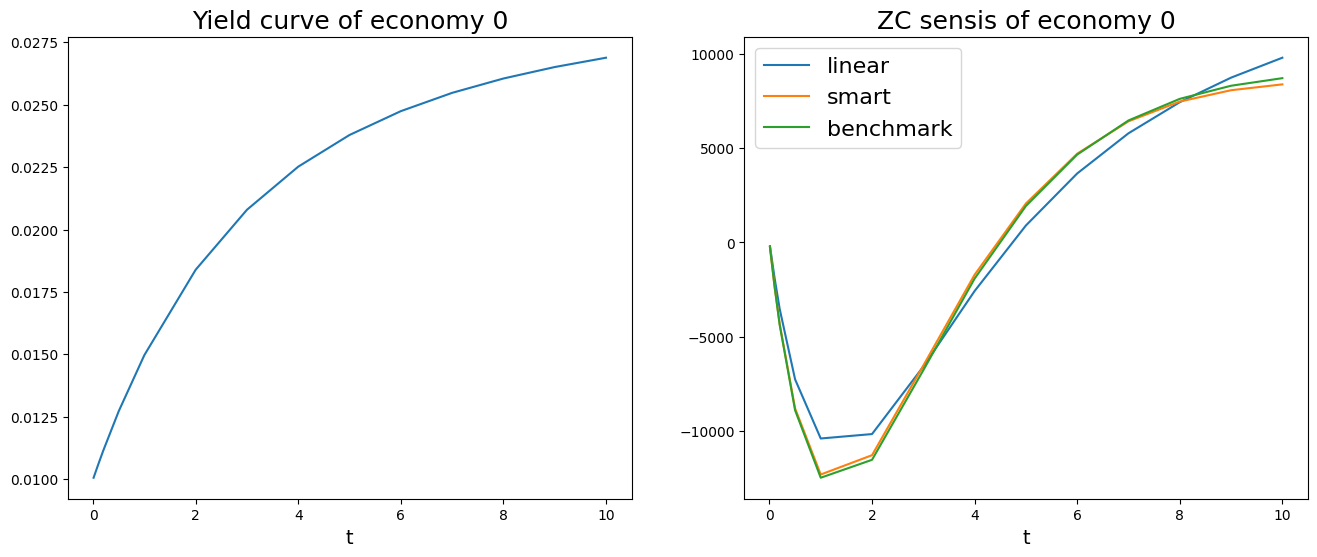

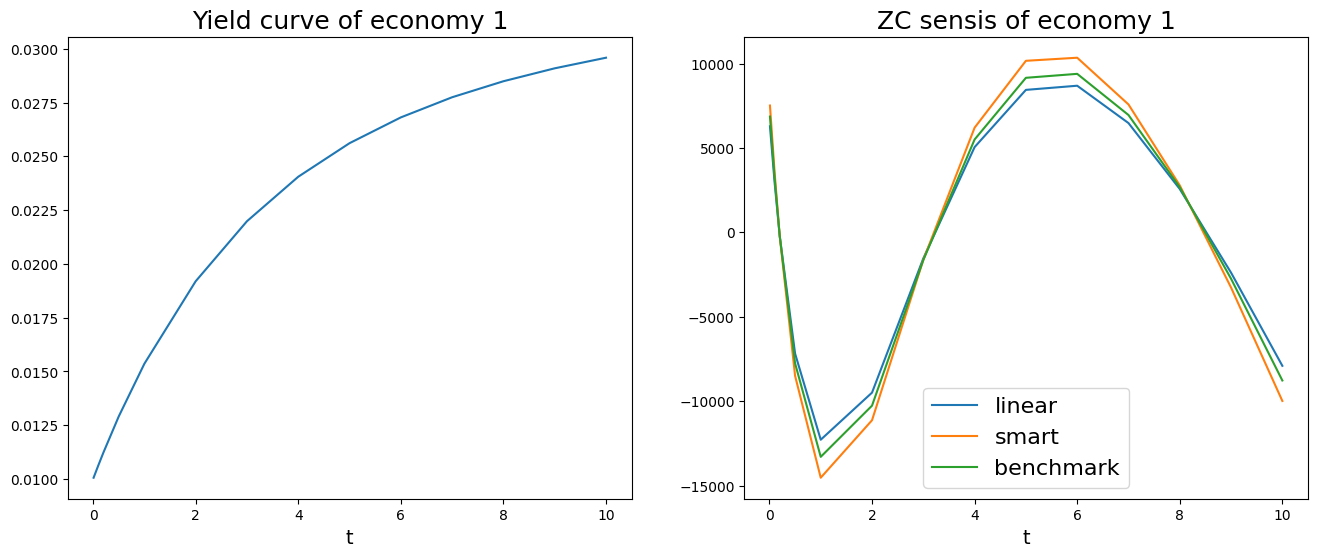

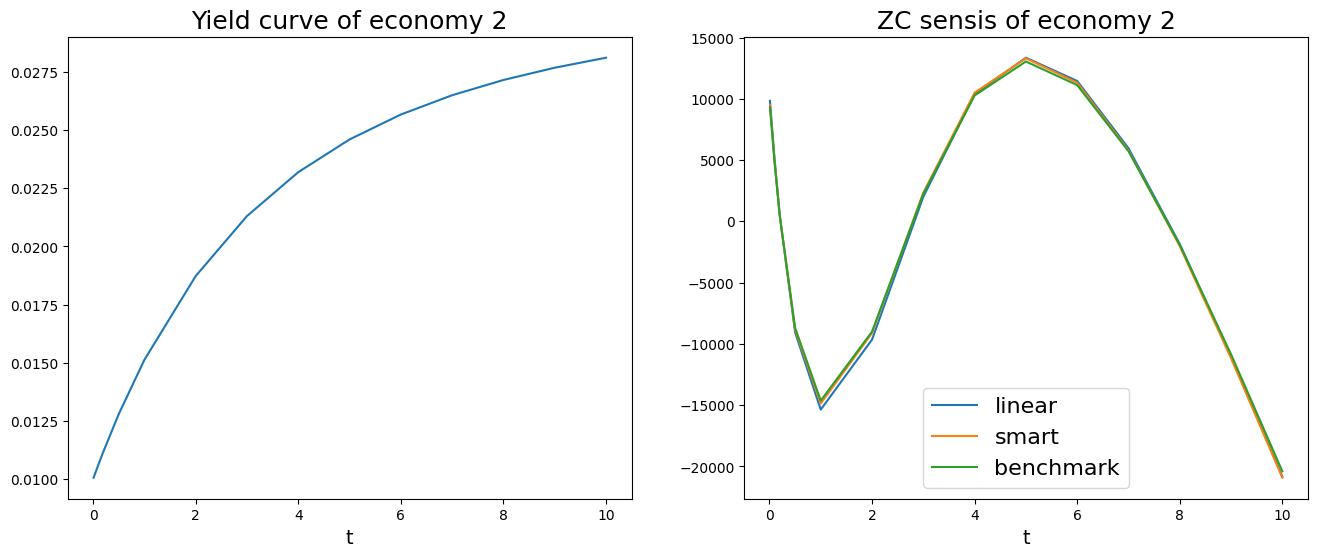

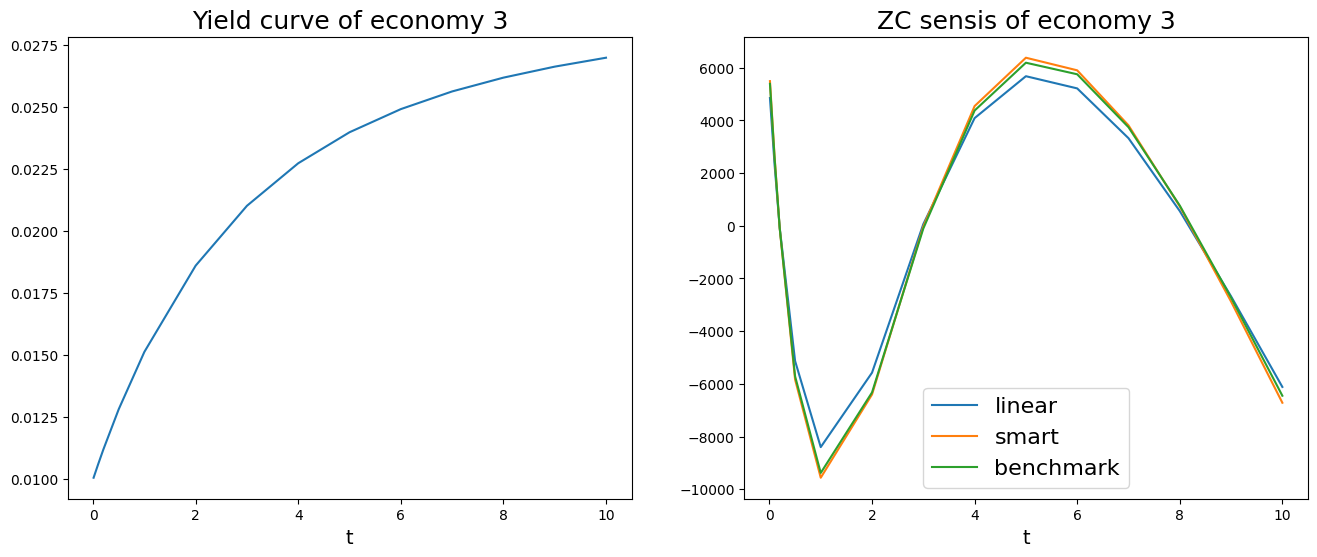

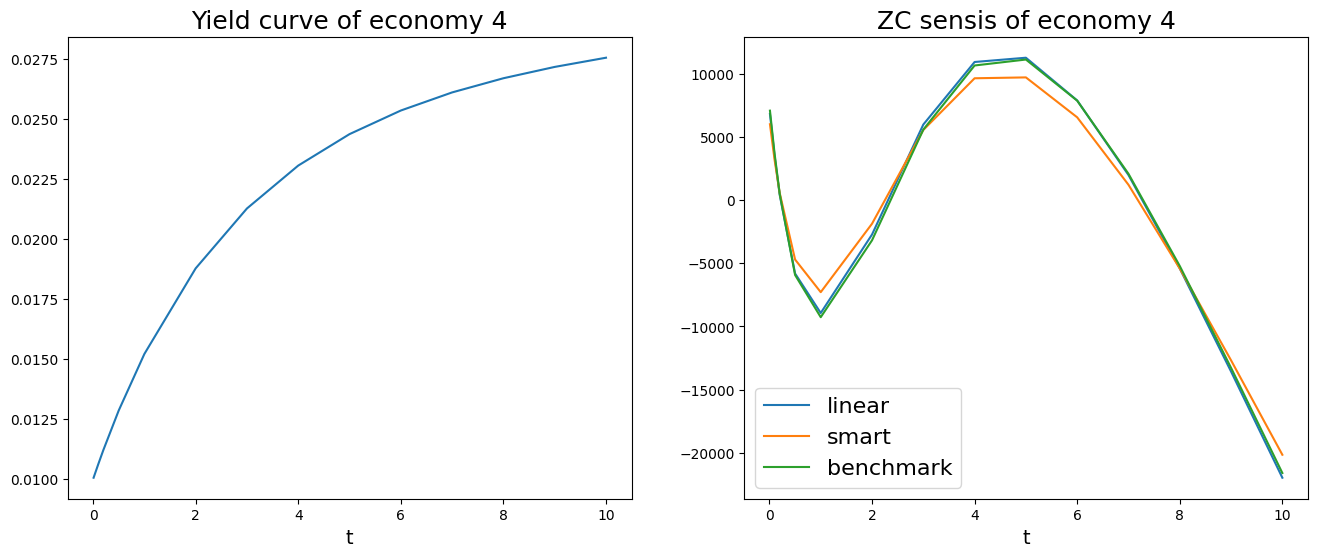

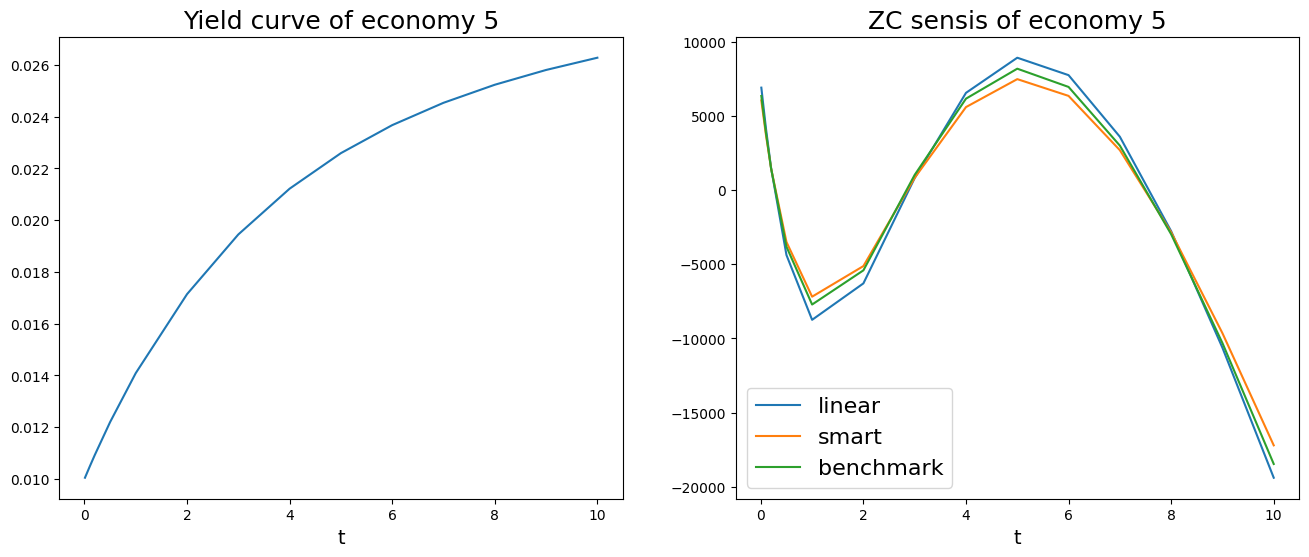

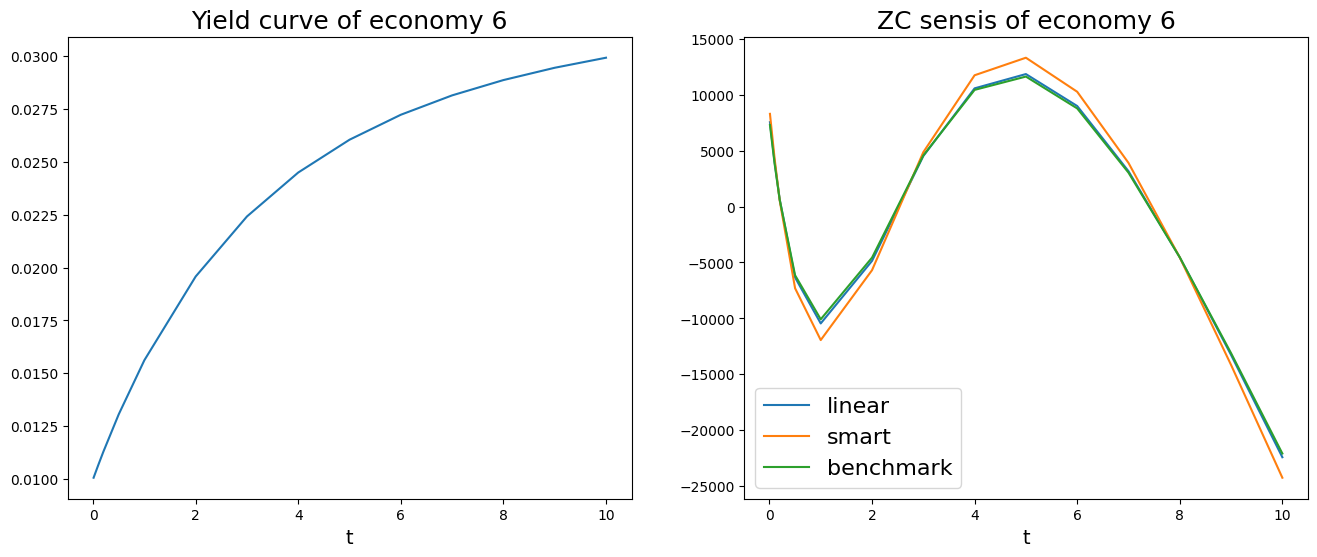

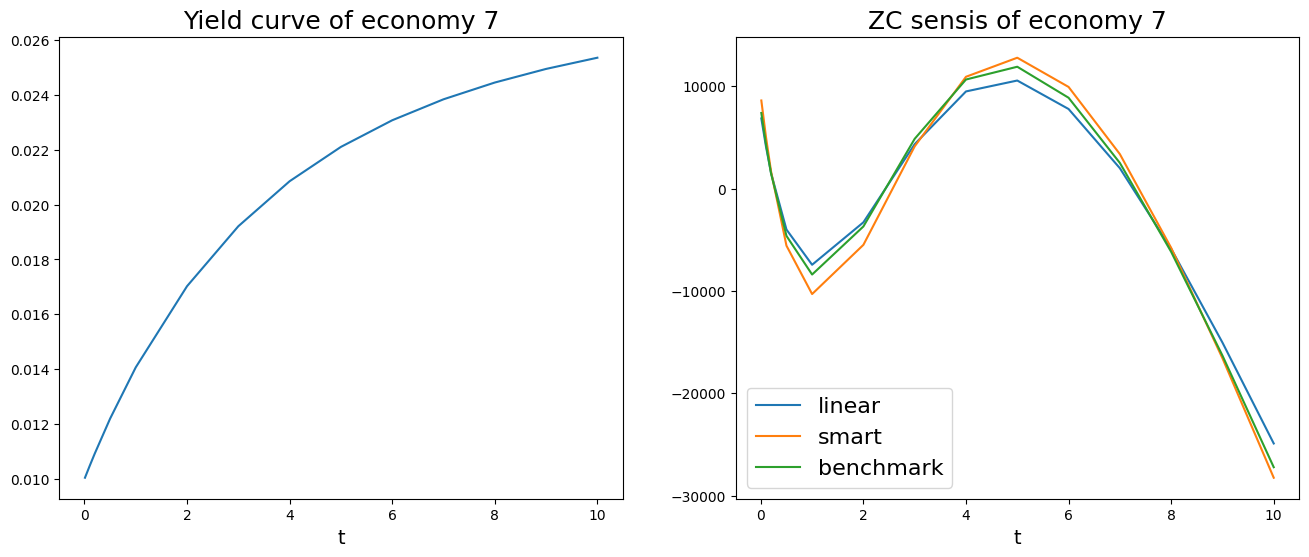

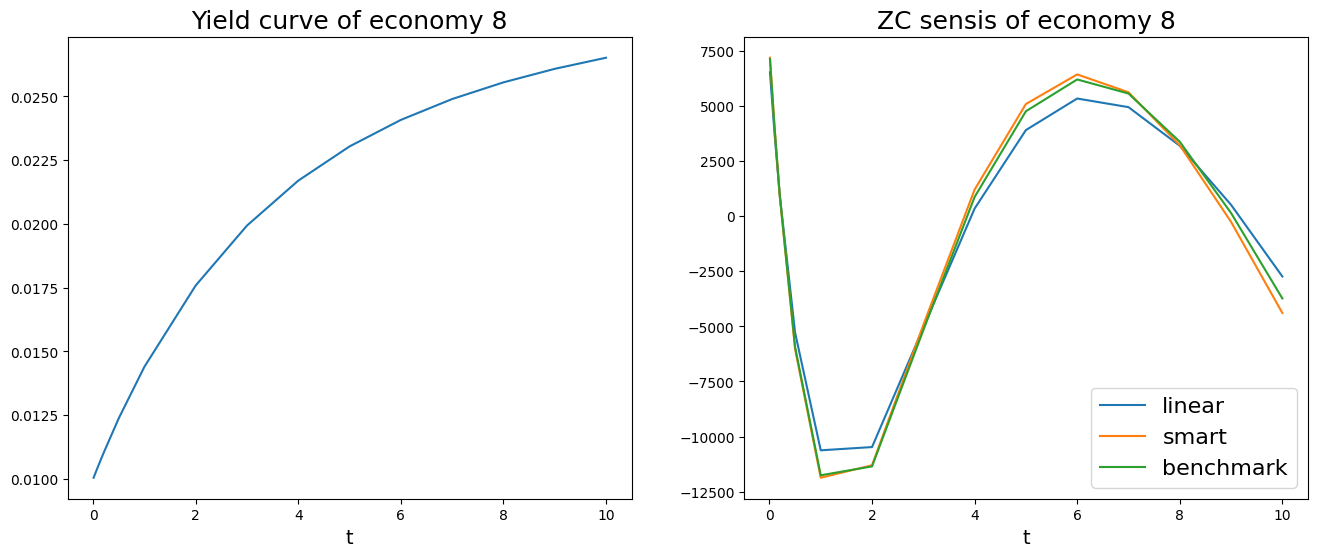

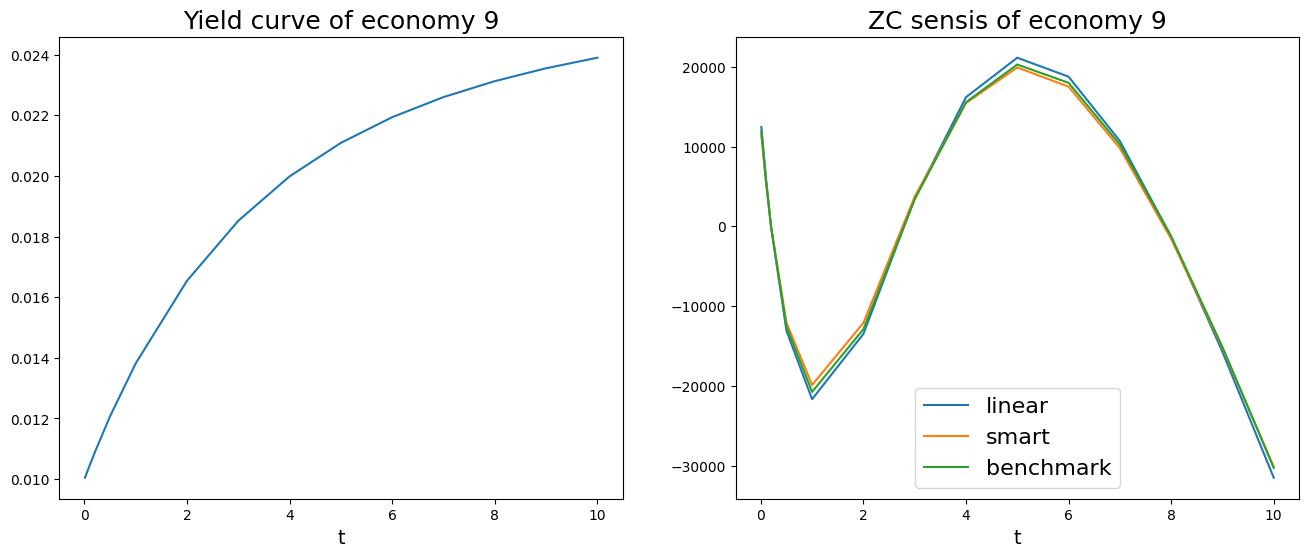

In [11]:
for edx in range(num_rates):

    plt.figure(figsize = (16,6))
    ax1 = plt.subplot(1,2,1)
    ax1.plot(zc_mat.cpu().numpy(),Yield_market[edx].cpu().numpy())
    #ax1.plot(zc_mat,(ZC_market))
    ax1.set_xlabel(r't',fontsize = 14)
    ax1.set_title('Yield curve of economy ' + str(edx),fontsize = 18)

    ax2 = plt.subplot(1,2,2)

    ax2.plot(zc_mat.cpu().numpy(), sensi_ZC_linear[edx], label = 'linear')
    ax2.plot(zc_mat.cpu().numpy(), sensi_ZC_smart[edx], label = 'smart')
    ax2.plot(zc_mat.cpu().numpy(), sensi_ZC_benchmark[edx], label = 'benchmark')

    ax2.set_title('ZC sensis of economy ' + str(edx),fontsize = 18)
    ax2.set_xlabel(r't',fontsize = 14)
    ax2.legend(fontsize = 16)
    plt.show()

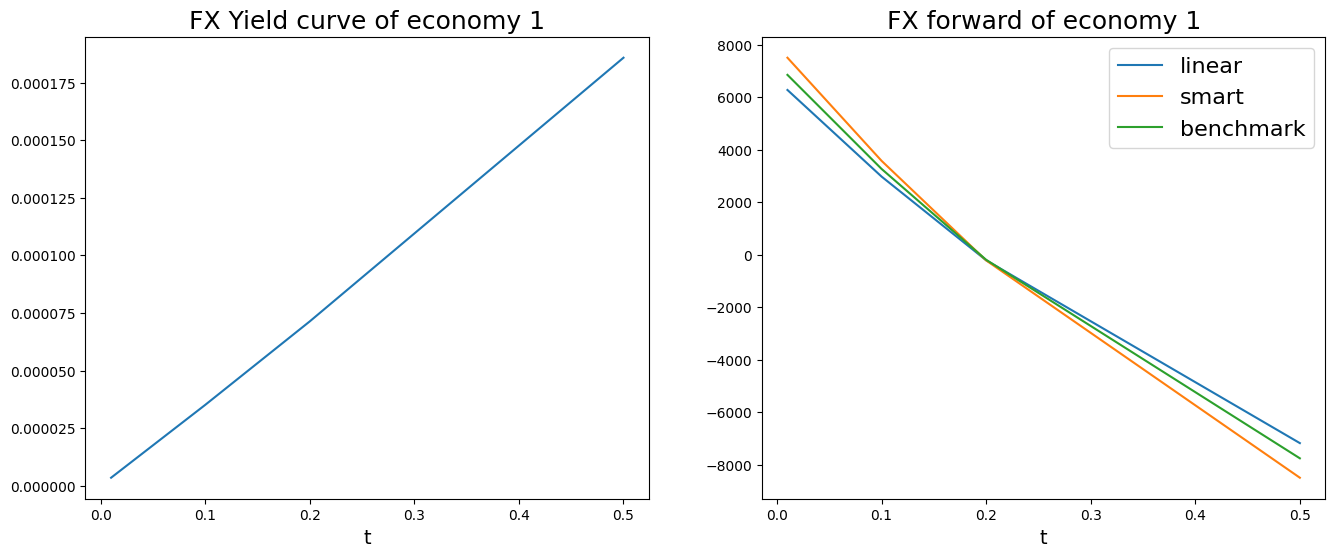

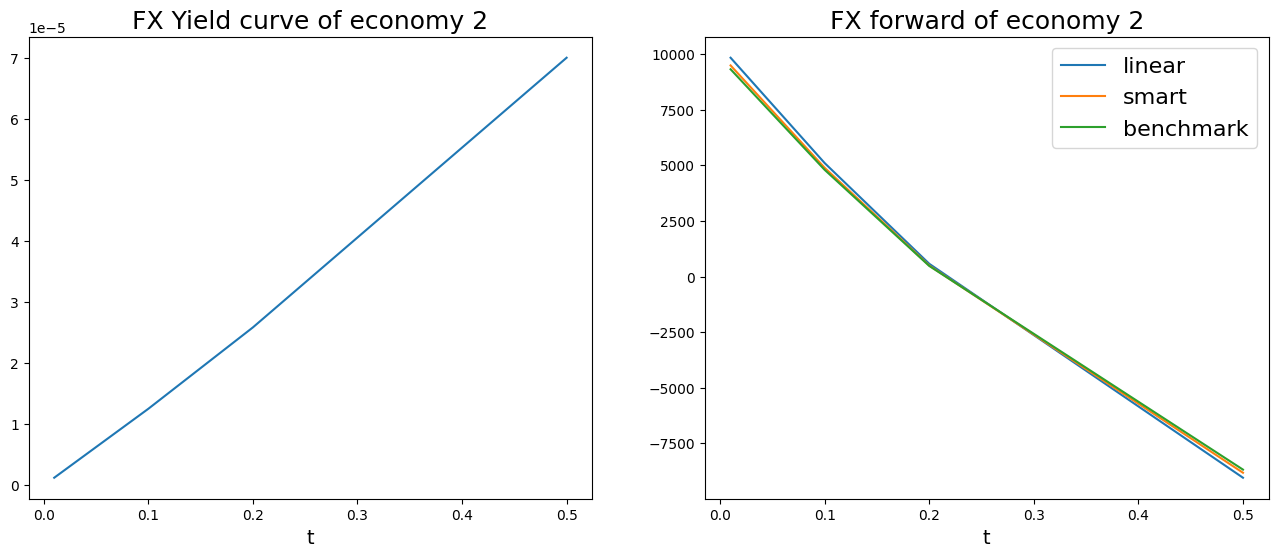

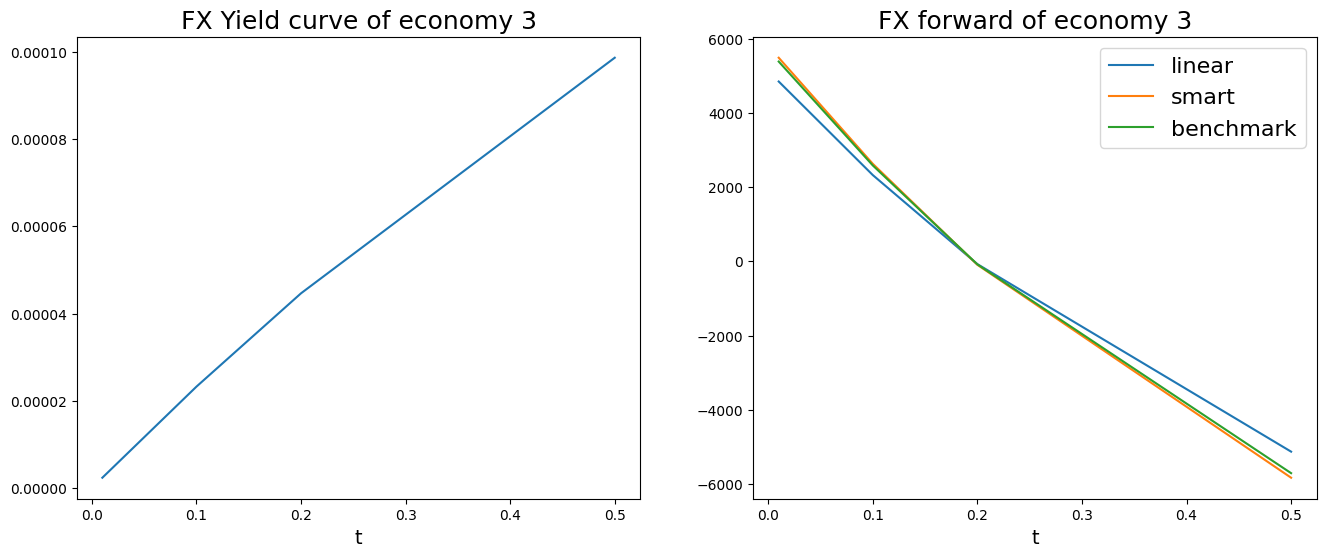

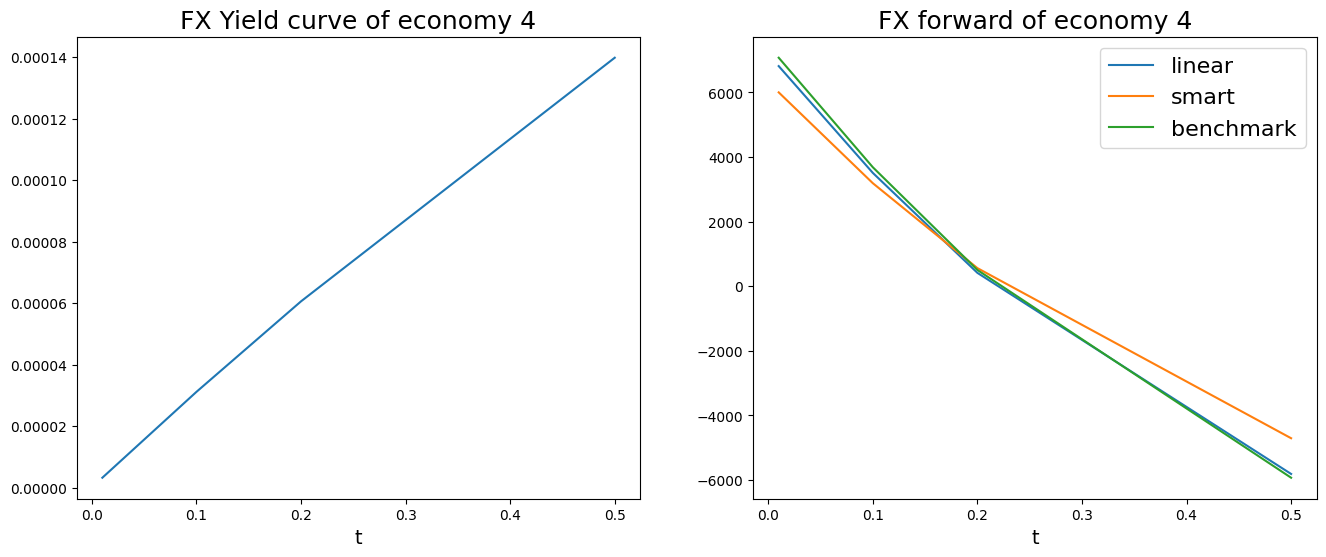

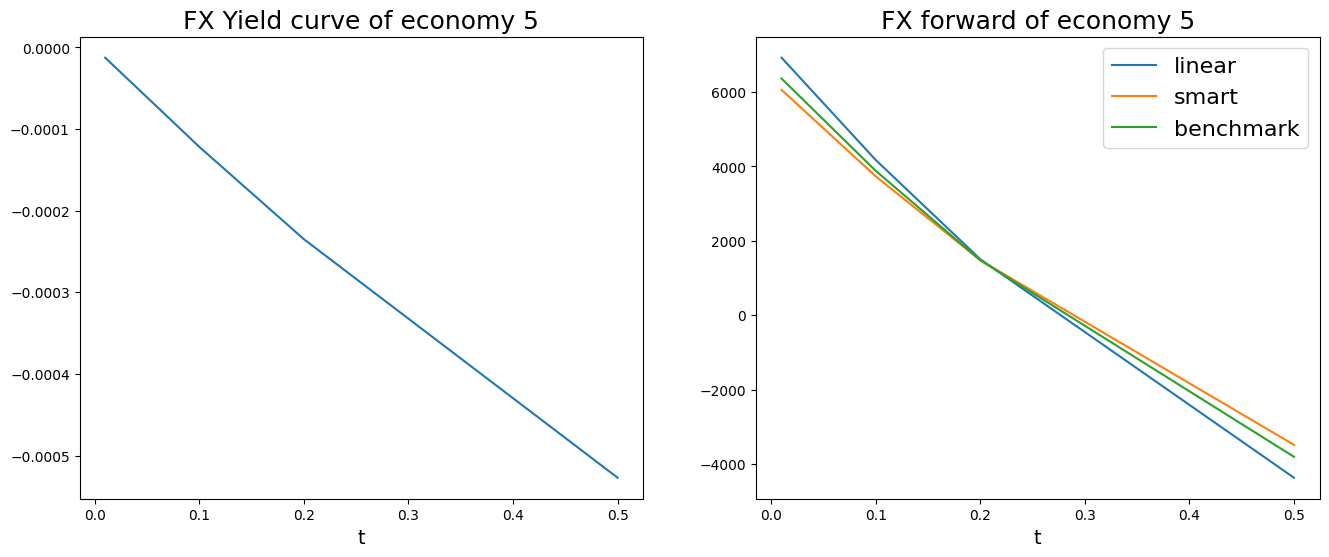

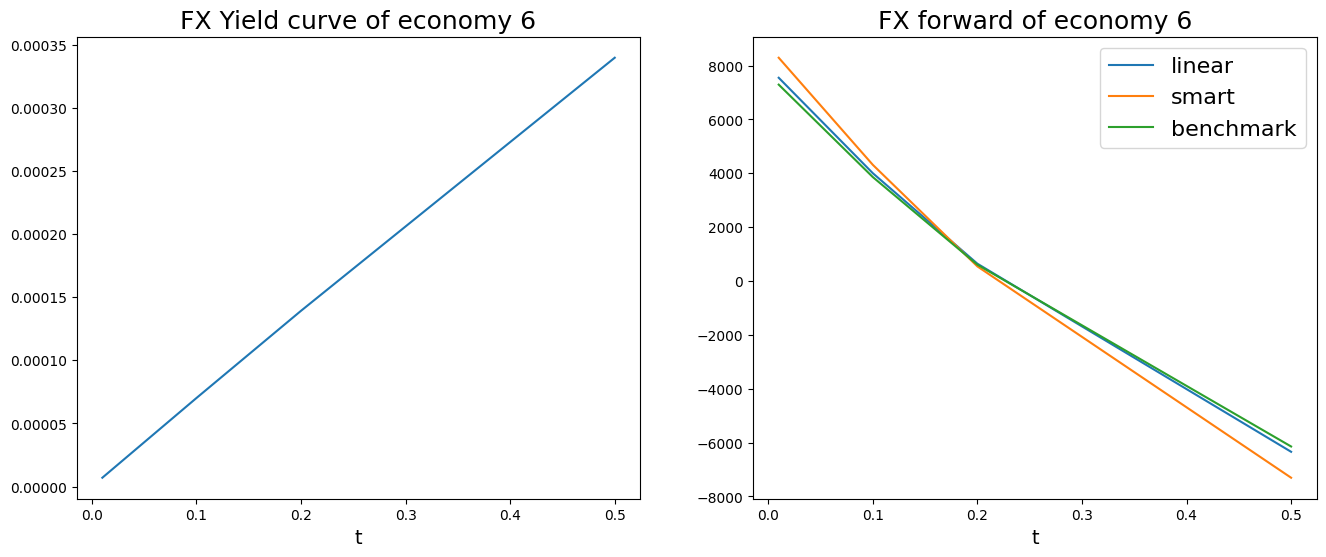

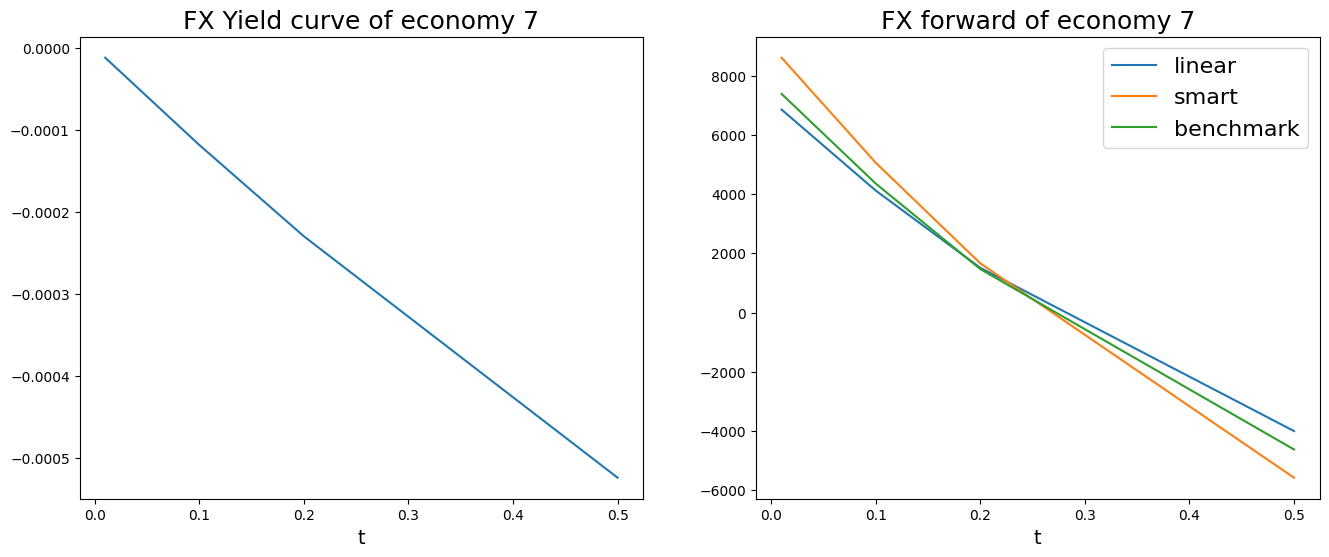

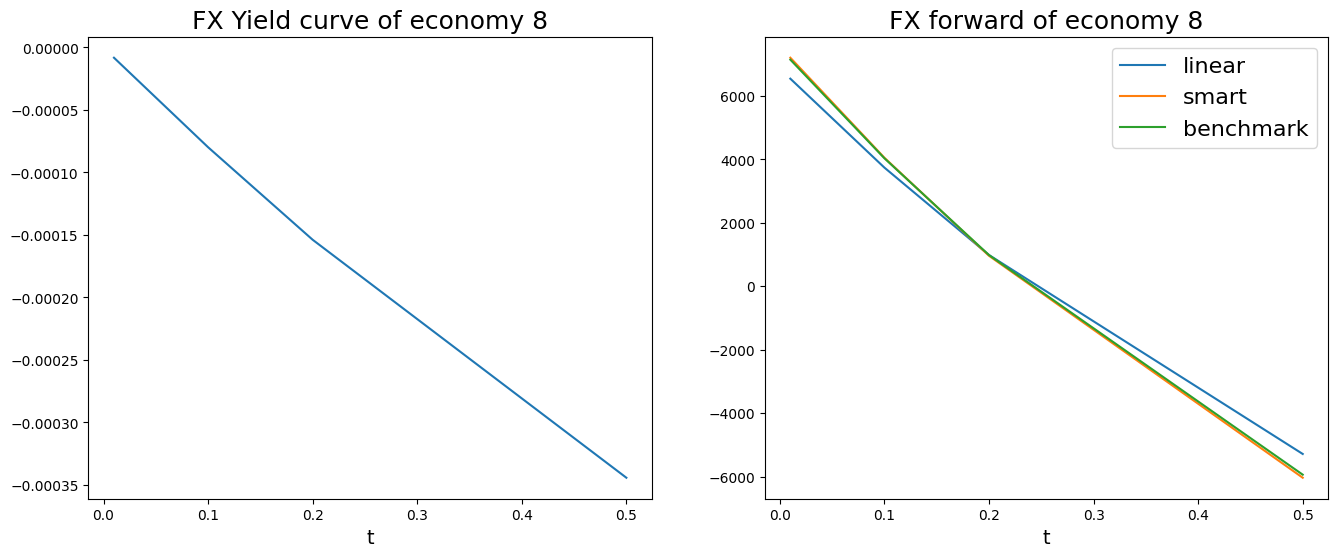

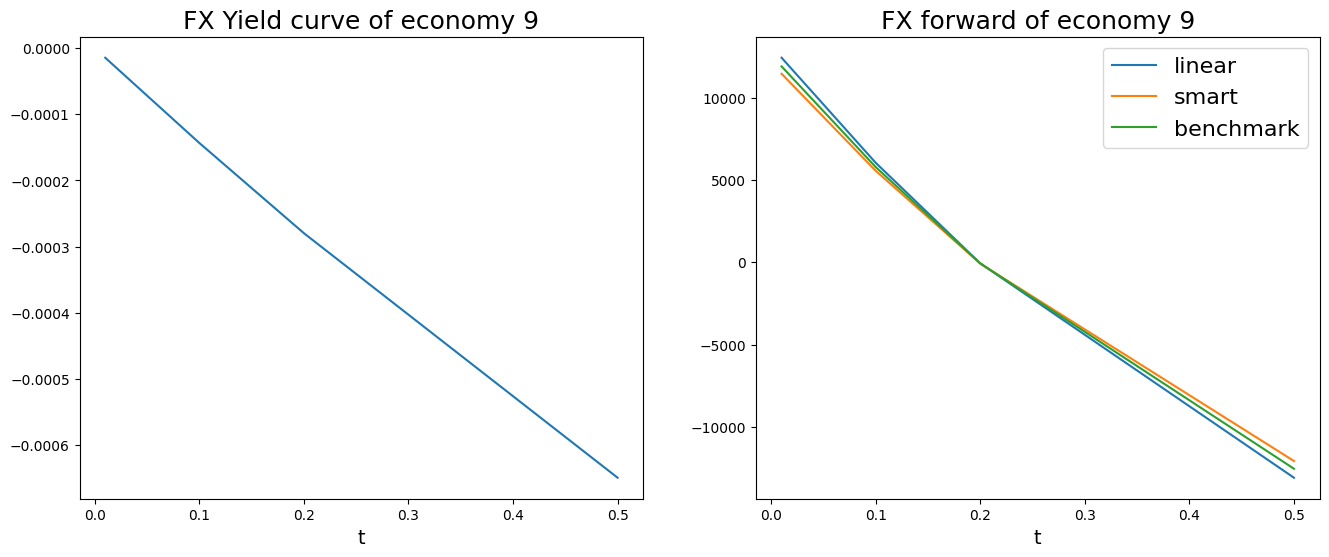

In [12]:
for edx in range(1,num_rates):

    plt.figure(figsize = (16,6))
    ax1 = plt.subplot(1,2,1)
    ax1.plot(zc_mat[0:4].cpu().numpy(), FX_Yield_market[edx-1][0:4].cpu().numpy() )
    ax1.set_xlabel(r't',fontsize = 14)
    ax1.set_title('FX Yield curve of economy ' + str(edx),fontsize = 18)

    ax2 = plt.subplot(1,2,2)

    ax2.plot(zc_mat[0:4].cpu().numpy(), sensi_FX_linear[edx-1][0:4], label = 'linear')
    ax2.plot(zc_mat[0:4].cpu().numpy(), sensi_FX_smart[edx-1][0:4], label = 'smart')
    ax2.plot(zc_mat[0:4].cpu().numpy(), sensi_FX_benchmark[edx-1][0:4], label = 'benchmark')

    ax2.set_title('FX forward of economy ' + str(edx),fontsize = 18)
    ax2.set_xlabel(r't',fontsize = 14)
    ax2.legend(fontsize = 16)
    plt.show()

## Sensitivities to CDS contracts

In [13]:
cds_mat = torch.tensor([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype = torch.float64)
lgd_rate = 0.6
Dt = 1/10 

ini_r_ref = torch.tensor(features_origial[group[0]][0], dtype = torch.float64)
a_r_ref = torch.tensor(features_origial[group[3]][0], dtype = torch.float64)
b_r_ref = torch.tensor(features_origial[group[4]][0], dtype = torch.float64)
sig_r_ref = torch.tensor(features_origial[group[5]][0], dtype = torch.float64)

In [14]:
def A_st(a,b,vvol,s,t):
    h = torch.sqrt(a**2+2*vvol**2)
    return (2*h*torch.exp((a+h)*(t-s)/2)/(2*h+(a+h)*(torch.exp(h*(t-s))-1)))**(2*a*b/vvol**2)
def B_st(a,vvol,s,t):
    h = torch.sqrt(a**2+2*vvol**2)
    return 2*(torch.exp(h*(t-s)) - 1)/(2*h+(a+h)*(torch.exp(h*(t-s))-1))

def delta_Proba_st(g_s, a, b, vvol, s, t):

    sqrt_term = torch.sqrt(a**2 + 2 * vvol**2)
    delta_t = t - s
    exp_delta_t_sqrt = torch.exp(delta_t * sqrt_term)
    exp_2_delta_t_sqrt = torch.exp(2 * delta_t * sqrt_term)

    term1 = a**3 * b * (-1 + exp_2_delta_t_sqrt)
    term2 = 2 * a * b * (-1 + exp_2_delta_t_sqrt) * vvol**2
    term3 = a**2 * (b * (-1 + exp_delta_t_sqrt)**2 + 2 * exp_delta_t_sqrt * g_s) * sqrt_term
    term4 = 4 * exp_delta_t_sqrt * g_s * vvol**2 * sqrt_term

    AA = 2**(1 + (2 * a * b) / vvol**2) * (term1 + term2 + term3 + term4)

    term5 = torch.exp(0.5 * delta_t * (a + sqrt_term))

    term6 = (term5 * sqrt_term)
    term7 = 2 * sqrt_term + (-1 + exp_delta_t_sqrt) * (a + sqrt_term)
    BB =  term6 / term7
    BB = BB**((2 * a * b) / vvol**2)

    CC = torch.exp(-((2 * (-1 + exp_delta_t_sqrt) * g_s) / term7))

    DD = sqrt_term * (a * (-1 + exp_delta_t_sqrt) + (1 + exp_delta_t_sqrt) * sqrt_term)**2

    result = -AA * BB * CC / DD

    return result

def P_survi_st(g_s, a,b,vvol,s,t):
    return A_st(a,b,vvol,s,t) * torch.exp(-B_st(a,vvol,s,t)*g_s)

In [15]:

def CDS_spread(phi, sig_spread, ini_r, a_r, b_r, sig_r,  T, LGD,  Dt, price = 0):
    T_list = torch.arange(float(Dt), float(T+Dt/2), float(Dt), dtype = torch.float64)
    def protection_int(u):
        return  pricer_ZC_tT(ini_r, a_r,b_r,sig_r,0,u) * delta_Proba_st(phi[0], phi[1], phi[2], sig_spread ,0,u )
    protection_leg = - LGD*integral(protection_int, torch.tensor([0], dtype = torch.float64), T)
    
    def accural_int(u):
        return  pricer_ZC_tT(ini_r, a_r,b_r,sig_r,0,u) * (u -  (u//Dt)*Dt)* delta_Proba_st(phi[0], phi[1], phi[2], sig_spread,0,u )
    
    premium_leg = torch.tensor([pricer_ZC_tT(ini_r,a_r,b_r,sig_r,0,t)*Dt*P_survi_st(phi[0], phi[1], phi[2], sig_spread, 0, t) for t in T_list], dtype = torch.float64).sum()
    premium_leg += -integral(accural_int, torch.tensor([0], dtype = torch.float64), T)
    return ( protection_leg-price)/premium_leg

def CDS_price(phi, sig_spread, ini_r, a_r, b_r, sig_r,  T, LGD,  Dt, cds_spread):
    T_list = torch.arange(float(Dt), float(T+Dt), float(Dt), dtype = torch.float64)
    def protection_int(u):
        return  pricer_ZC_tT(ini_r, a_r,b_r,sig_r,0,u) * delta_Proba_st(phi[0], phi[1], phi[2], sig_spread ,0,u )
    protection_leg = - LGD*integral(protection_int, torch.tensor([0], dtype = torch.float64), T)
    
    def accural_int(u):
        return  pricer_ZC_tT(ini_r, a_r,b_r,sig_r,0,u) * (u -  (u//Dt)*Dt)* delta_Proba_st(phi[0], phi[1], phi[2] , sig_spread,0,u)
    
    premium_leg = torch.tensor([pricer_ZC_tT(ini_r,a_r,b_r,sig_r,0,t)*Dt*P_survi_st(phi[0], phi[1], phi[2], sig_spread, 0, t) for t in T_list], dtype = torch.float64).sum()
    premium_leg += -integral(accural_int, torch.tensor([0], dtype = torch.float64), T)
    return protection_leg - cds_spread*premium_leg



def loss_calib_CDS(cds_market, phi, sig_spread, ini_rate, a_rate, b_rate, sig_rate, lgd_rate, Dt, cds_spread_market):
    loss = 0.
    for mcds, ms, mat in zip(cds_market, cds_spread_market, cds_mat):
        #loss += (CDS_spread(phi, sig_spread,  a_rate, b_rate, ini_rate, sig_rate, mat, lgd, Dt, mcds ) - 
        #        ms )**2
        loss += (CDS_price(phi, sig_spread, ini_rate, a_rate, b_rate, sig_rate, mat, lgd_rate, Dt, ms ) - mcds )**2
    return loss


def jab_matrix(ini_s, a_s, b_s, sig_s, ini_rate, a_rate, b_rate, sig_rate, cds_mat, lgd_rate, Dt):

    phi = torch.tensor([ini_s, a_s, b_s], dtype = torch.float64)
    market_spread = torch.tensor([CDS_spread(phi, sig_s, ini_rate, a_rate, b_rate, sig_rate, T, lgd_rate, Dt) for T in cds_mat], dtype = torch.float64)
    market_cds = torch.tensor([CDS_price(phi, sig_s, ini_rate, a_rate, b_rate, sig_rate, T, lgd_rate, Dt, market_spread[i]) for i,T in enumerate(cds_mat)], dtype = torch.float64)

    hess_phi = ft_hessian(loss_calib_CDS, argnums=1)(market_cds, phi, sig_s, ini_rate, a_rate, b_rate, sig_rate, lgd_rate, Dt , market_spread).to(dtype = torch.float64)    
    jac_phi_pi = jacfwd(jacfwd(loss_calib_CDS, argnums=0), argnums=1)(market_cds, phi, sig_s, ini_rate, a_rate, b_rate, sig_rate, lgd_rate, Dt , market_spread).to(dtype = torch.float64)                                        

    hess_phi_inv = torch.inverse(hess_phi)
    return -torch.matmul(jac_phi_pi,hess_phi_inv).cpu().numpy().T


In [16]:

cds_jacobians = []

for i in range(num_spreads - 1):
    ini_s = features_origial[group[2]][i]
    a_s = features_origial[group[7]][i]
    b_s = features_origial[group[8]][i]
    sig_s = features_origial[group[9]][i]
    res = jab_matrix(ini_s, a_s, b_s, sig_s, ini_r_ref, a_r_ref, b_r_ref, sig_r_ref, cds_mat, lgd_rate, Dt)
    cds_jacobians.append(res)

/home/hdnguyen/miniconda3/envs/env/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/hdnguyen/miniconda3/envs/env/lib/python3.11/site-packages/torchquad/integration/utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


In [17]:
sensi_CDS_linear = list()
sensi_CDS_benchmark = list()
sensi_CDS_smart = list()

CDS_spread_market = list()

for edx in range(num_spreads - 1):

    ini_s = torch.tensor(features_origial[group[2]][edx], dtype = torch.float64)
    a_s = torch.tensor(features_origial[group[7]][edx], dtype = torch.float64)
    b_s = torch.tensor(features_origial[group[8]][edx], dtype = torch.float64)
    sig_s = torch.tensor(features_origial[group[9]][edx], dtype = torch.float64)

    cds_curve = torch.tensor([CDS_spread(torch.tensor([ini_s, a_s, b_s]), sig_s, ini_r_ref, a_r_ref, b_r_ref, sig_r_ref, T, lgd_rate, Dt) for T in cds_mat], dtype = torch.float64) 
    CDS_spread_market.append(cds_curve)
    tab_ini_s = tab_sensi[tab_sensi['idx'] == group[2][edx]]
    tab_a_s = tab_sensi[tab_sensi['idx'] == group[7][edx]]
    tab_b_s = tab_sensi[tab_sensi['idx'] == group[8][edx]]
    tab_sig_s = tab_sensi[tab_sensi['idx'] == group[9][edx]]

    sensi_phi_spread_linear = np.array([tab_ini_s['linear'], tab_a_s['linear'], tab_b_s['linear']], dtype = np.float32).reshape(1,3)
    sensi_phi_spread_benchmark = np.array([tab_ini_s['benchmark'], tab_a_s['benchmark'], tab_b_s['benchmark']], dtype = np.float32).reshape(1,3)
    sensi_phi_spread_smart = np.array([tab_ini_s['smart'], tab_a_s['smart'], tab_b_s['smart']], dtype = np.float32).reshape(1,3)

    sensi_CDS_linear.append(np.matmul(sensi_phi_spread_linear, cds_jacobians[edx]).ravel())
    sensi_CDS_benchmark.append(np.matmul(sensi_phi_spread_benchmark, cds_jacobians[edx]).ravel())
    sensi_CDS_smart.append(np.matmul(sensi_phi_spread_smart, cds_jacobians[edx]).ravel())
    
CDS_spread_market = torch.cat([cs.reshape(1,-1) for cs in CDS_spread_market])

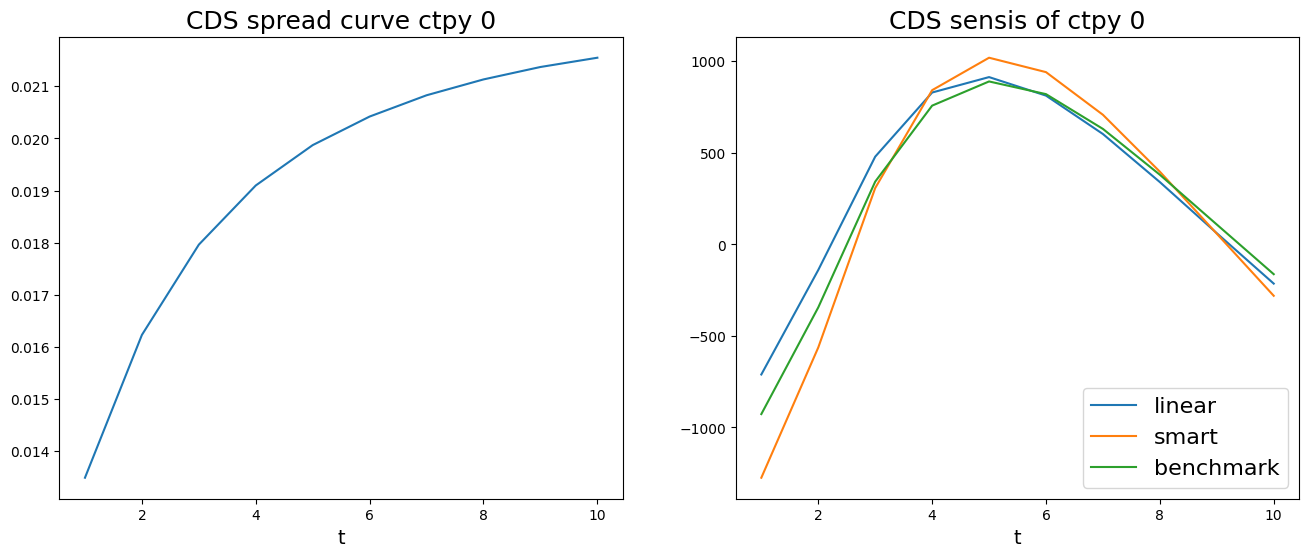

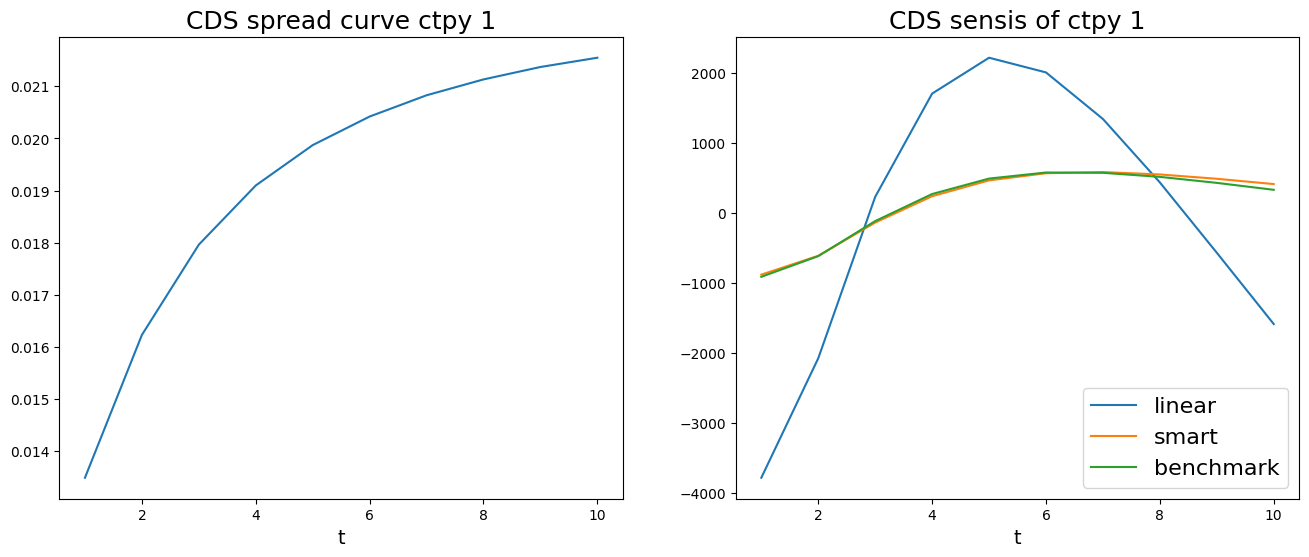

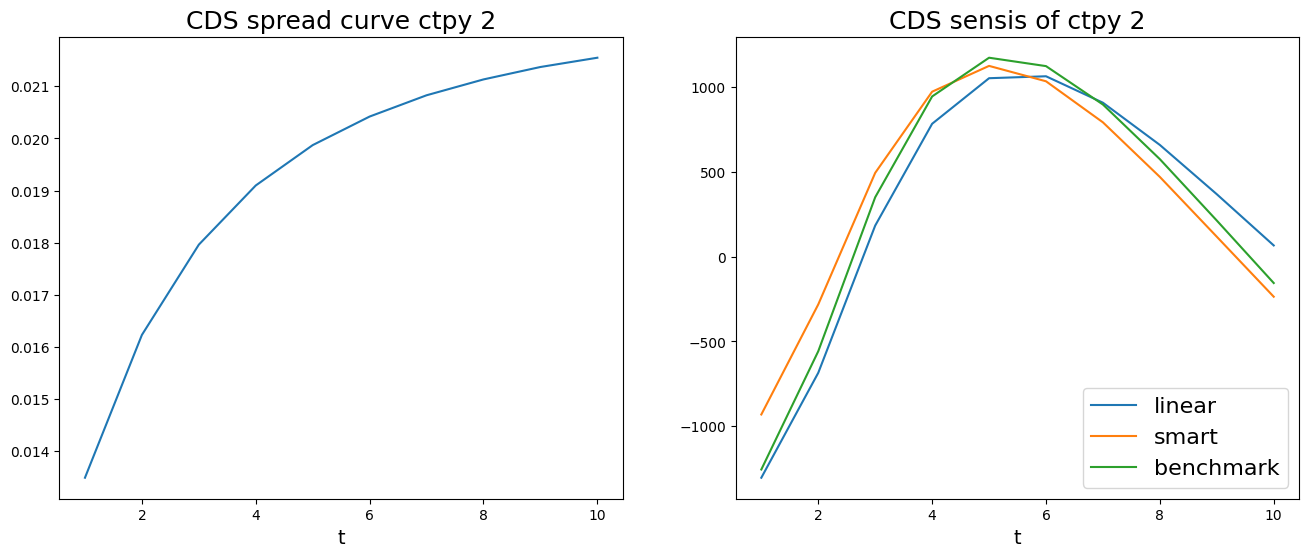

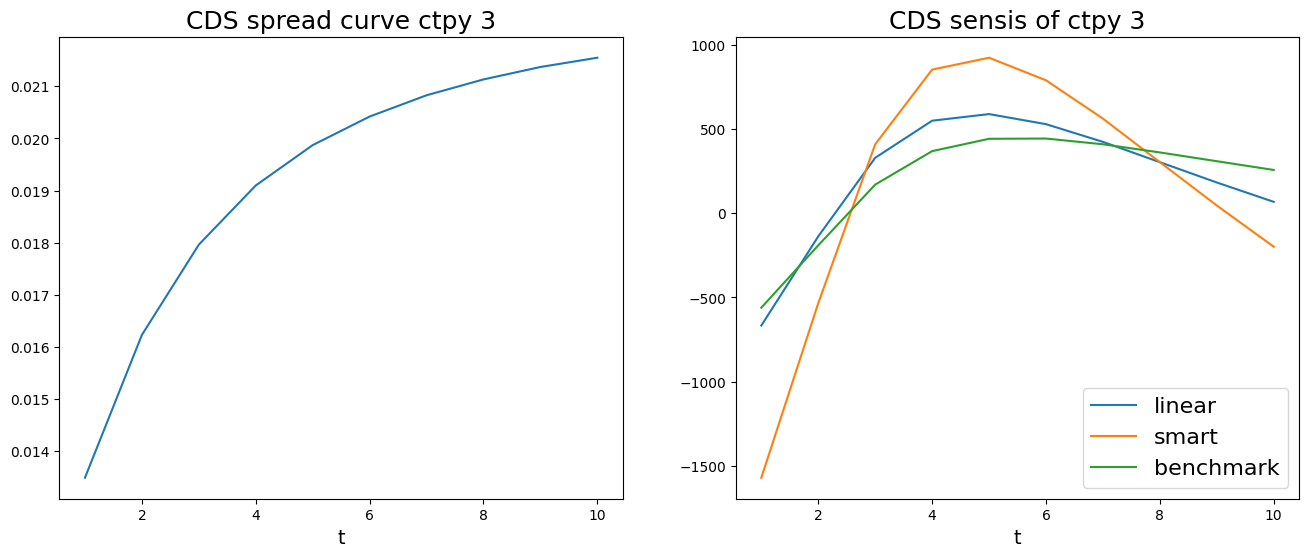

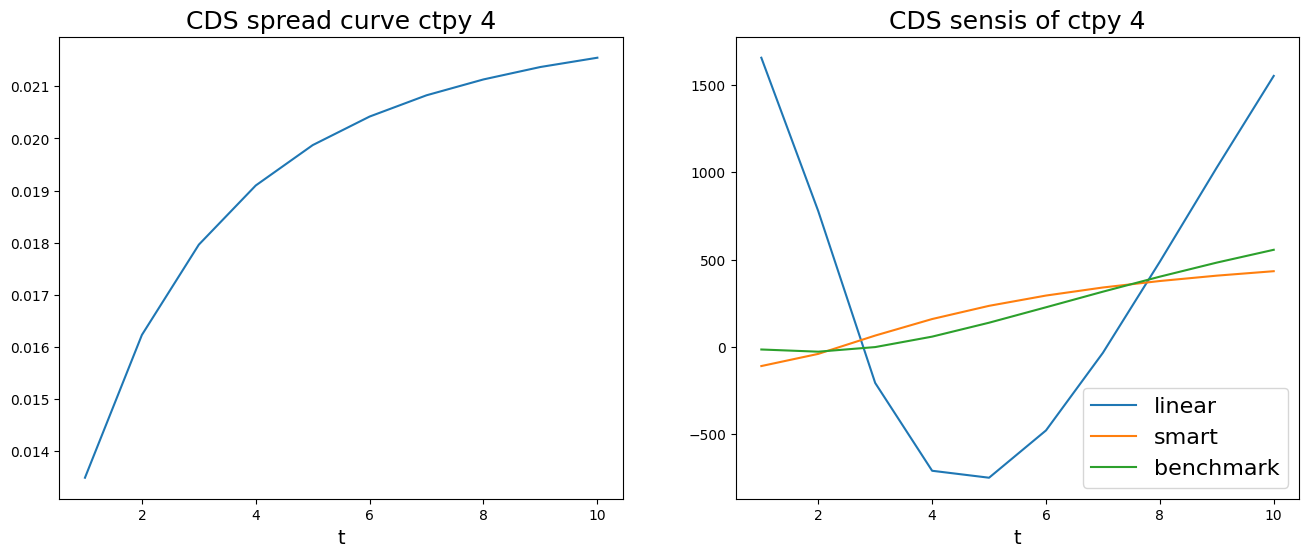

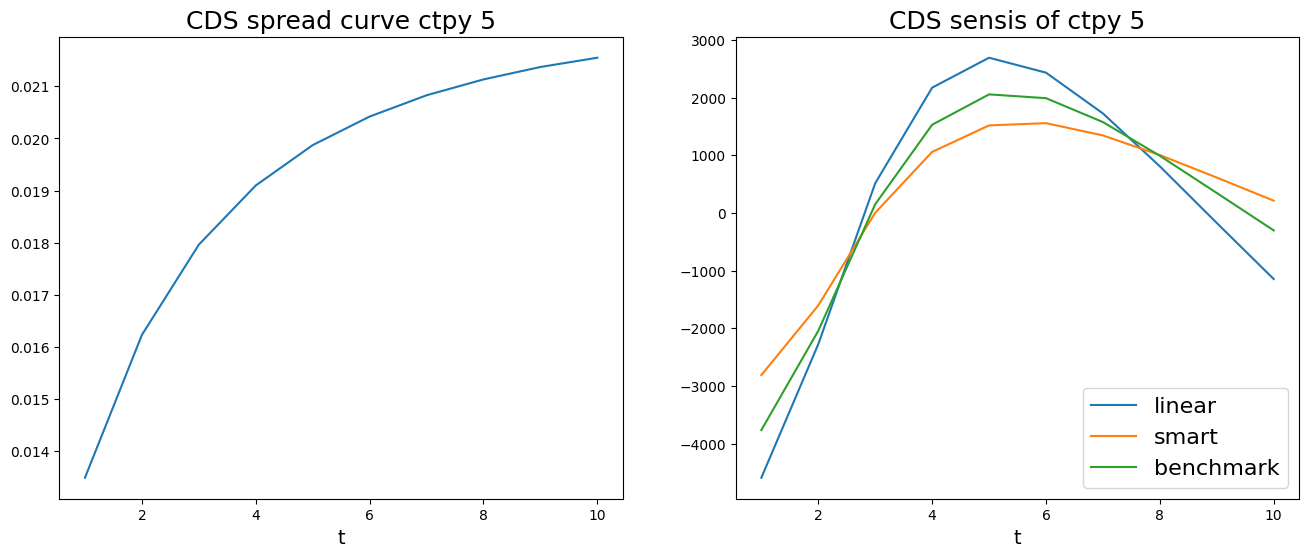

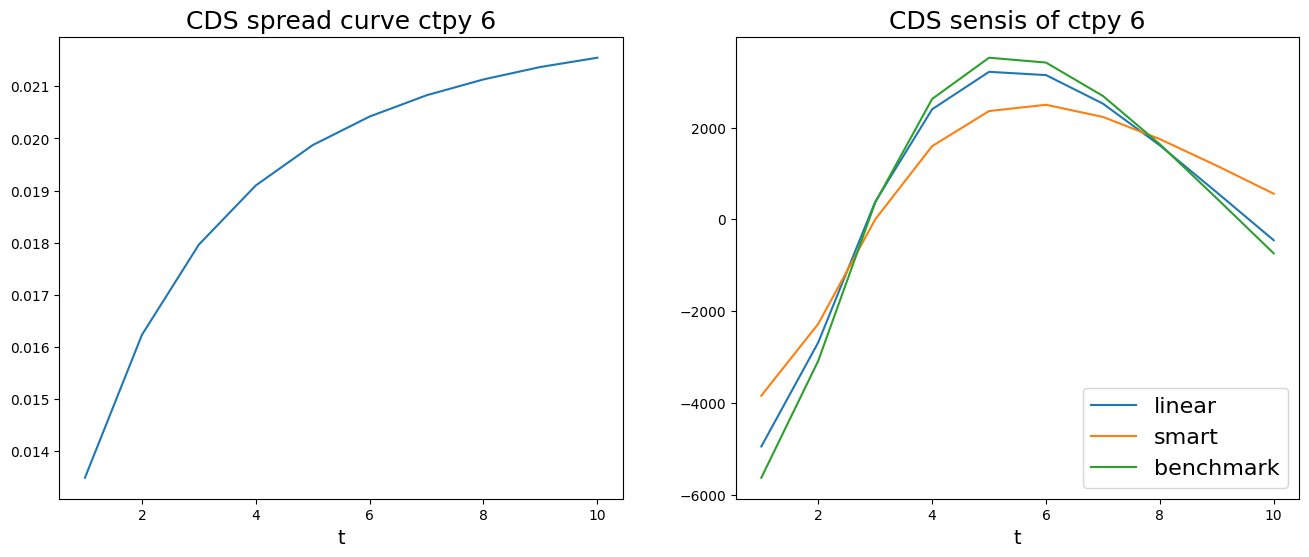

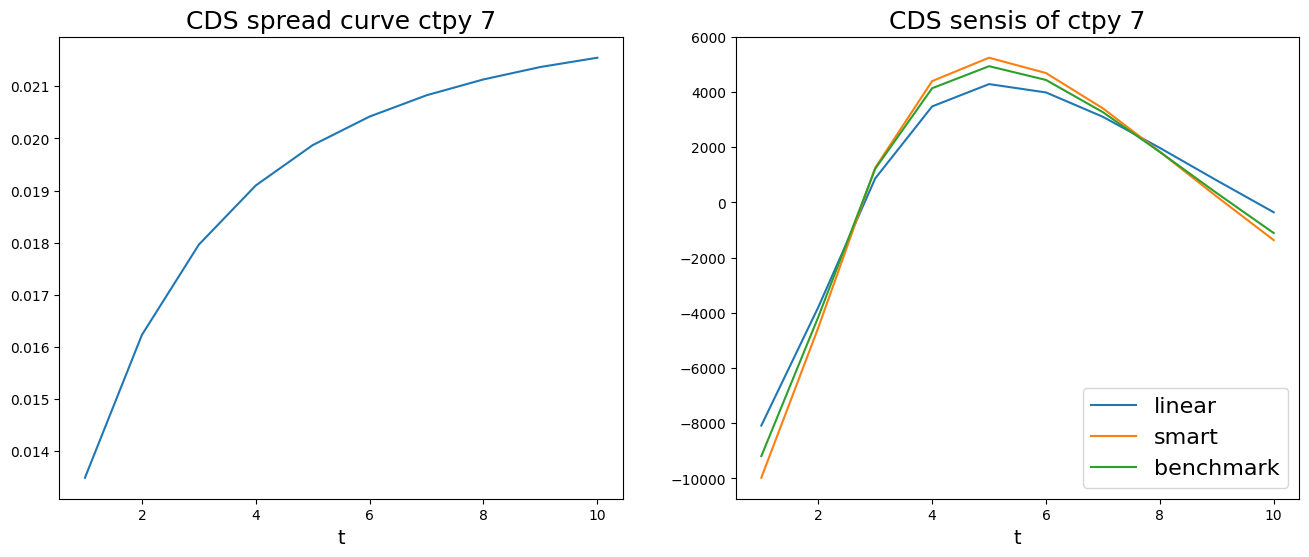

In [18]:
for edx in range(num_spreads - 1):
    
    plt.figure(figsize = (16,6))
    ax1 = plt.subplot(1,2,1)
    ax1.plot(cds_mat.cpu().numpy(),cds_curve.cpu().numpy())
    #ax1.plot(zc_mat,(ZC_market))
    ax1.set_xlabel(r't',fontsize = 14)
    ax1.set_title('CDS spread curve ctpy ' + str(edx),fontsize = 18)

    ax2 = plt.subplot(1,2,2)

    ax2.plot(cds_mat.cpu().numpy(), sensi_CDS_linear[edx], label = 'linear')
    ax2.plot(cds_mat.cpu().numpy(), sensi_CDS_smart[edx], label = 'smart' )
    ax2.plot(cds_mat.cpu().numpy(), sensi_CDS_benchmark[edx], label = 'benchmark')

    ax2.set_title('CDS sensis of ctpy ' + str(edx) ,fontsize = 18)
    ax2.set_xlabel(r't',fontsize = 14)
    ax2.legend(fontsize = 16)
    plt.show()

In [19]:
sensis_market_benchmark = np.concatenate([np.array(sensi_ZC_benchmark).reshape(1,-1), 
                               np.array(sensi_FX_benchmark).reshape(1,-1),
                               np.array(sensi_CDS_benchmark).reshape(1,-1)
                               ], axis = 1)

sensis_market_smart = np.concatenate([np.array(sensi_ZC_smart).reshape(1,-1), 
                               np.array(sensi_FX_smart).reshape(1,-1),
                               np.array(sensi_CDS_smart).reshape(1,-1)
                               ], axis = 1)

sensis_market_linear = np.concatenate([np.array(sensi_ZC_linear).reshape(1,-1), 
                               np.array(sensi_FX_linear).reshape(1,-1),
                               np.array(sensi_CDS_linear).reshape(1,-1)
                               ], axis = 1)

# Computing market instruments in each simulated paths 

In [20]:

def CDS_price_vector(ini_s, a_s, b_s, sig_s, ini_r, a_r, b_r, sig_r,  T, LGD,  Dt,cds_spread):
    T_list = torch.arange(float(Dt), float(T+Dt/2), float(Dt), dtype = torch.float64)
    
    def protection_int(u):
        return  pricer_ZC_tT(ini_r, a_r,b_r,sig_r,0,u) * delta_Proba_st(ini_s, a_s, b_s, sig_s,0,u)
    
    protection_leg = -LGD*integral(protection_int, torch.tensor([0], dtype = torch.float64), T)
    
    def accural_int(u):
        return  pricer_ZC_tT(ini_r, a_r,b_r,sig_r,0,u) * (u -  (u//Dt)*Dt)* delta_Proba_st(ini_s, a_s, b_s, sig_s,0,u)
    
    premium_leg = [(pricer_ZC_tT(ini_r, a_r,b_r,sig_r,0,t)*Dt*P_survi_st(ini_s, a_s, b_s, sig_s, 0, t)).reshape(-1,1) for t in T_list]
    premium_leg = torch.cat(premium_leg,dim = 1)
    premium_leg = premium_leg.sum(dim = 1)
    premium_leg += -integral(accural_int, torch.tensor([0], dtype = torch.float64), T)
    
    return protection_leg - cds_spread*premium_leg


def market_price_calculator(paths, horizon ):
    
    ZC_market = list()
    FX_market = list()
    N = len(paths)
    for edx in range(num_rates):

        ini = torch.tensor(paths[:,edx:edx+1], dtype = torch.float64)
        a = torch.tensor(paths[:,27+edx:27+edx+1], dtype = torch.float64)
        b = torch.tensor(paths[:,37+edx:37+edx+1], dtype = torch.float64)
        sig = torch.tensor(paths[:,47+edx:47+edx+1], dtype = torch.float64)
        

        zc_curve = pricer_ZC_tT(ini, a,b,sig, 0, zc_mat).cpu().numpy()[:, np.newaxis, :]
        if edx == 0:
            zc_ref = zc_curve.copy()
            ZC_market.append( zc_curve)
        else:
            ZC_market.append( zc_curve*paths[:,num_rates+edx-1].reshape(-1,1,1))
        
            fx_curve = zc_curve/zc_ref*paths[:,num_rates+edx-1].reshape(-1,1,1) - FX_strike[edx-1].reshape(1,1,-1).cpu().numpy() 
            fx_curve *= zc_ref
            
            FX_market.append(fx_curve[:,:,0:4])
    ZC_market = np.concatenate(ZC_market, axis = 1)
    FX_market = np.concatenate(FX_market, axis = 1)

    if horizon ==0:
        CDS_market =  np.zeros((N, 8,10), dtype = np.float32)
    else:
        CDS_market = list()

        ini = torch.tensor(paths[:,0], dtype = torch.float64)
        a = torch.tensor(paths[:,27], dtype = torch.float64)
        b = torch.tensor(paths[:,37], dtype = torch.float64)
        sig = torch.tensor(paths[:,47], dtype = torch.float64)

        for edx in range(num_spreads - 1):

            ini_s = torch.tensor(paths[:,19+edx], dtype = torch.float64)
            a_s = torch.tensor(paths[:,66+edx], dtype = torch.float64)
            b_s = torch.tensor(paths[:,74+edx], dtype = torch.float64)
            sig_s = torch.tensor(paths[:,82+edx], dtype = torch.float64)

            cds_price = torch.cat([CDS_price_vector(ini_s, a_s, b_s, sig_s, ini, a, b, sig, T, lgd_rate, Dt,CDS_spread_market[edx][i] ).reshape(-1,1) for i,T in enumerate(cds_mat)], dim = 1)
            CDS_market.append( cds_price[:,np.newaxis, : ].cpu().numpy())
        CDS_market = np.concatenate(CDS_market, axis = 1)
    
    

    return np.concatenate([ZC_market.reshape(len(ZC_market),-1),
                           FX_market.reshape(len(FX_market),-1),
                           CDS_market.reshape(len(CDS_market),-1),
                          ], axis = 1)

In [21]:
features_market0 = market_price_calculator(features_baseline0, horizon=0)

features_market_train = np.empty((3, features_train.shape[1], features_market0.shape[1]))

features_market_test = np.empty((3, features_test.shape[1], features_market0.shape[1]))

for i in tqdm(range(3)):
    features_market_train[i,:,:] = market_price_calculator(features_train[i], 1)
    features_market_test[i,:,:] = market_price_calculator(features_test[i], 1)


100%|███████████████████████████████████████████| 3/3 [01:01<00:00, 20.54s/it]


Compute delta market and model risk factors

In [22]:
d_features_market_train = features_market_train - features_market0[np.newaxis,:,:]
d_features_market_test = features_market_test - features_market0[np.newaxis,:,:]

d_features_train = (features_train -features_baseline0)
d_features_test = (features_test -features_baseline0)

# Run-on CVA risk

In [42]:
from tool import ES_Regression, poly_square, hedging_error_standardized, pl_explain,twin_score, var_score, es_score


In [43]:

def adj_predict(model, X, d_cva = 0):        
    model.intercept_ = 0
    pred = model.predict(X).reshape(-1,1)
    c = d_cva.reshape(-1,1).mean() - pred.mean()
    return  pred+c

In [44]:
model_para_benchmark_gamma = LinearRegression(fit_intercept=True)
model_para_smart = LinearRegression(fit_intercept=True)
model_para_linear = LinearRegression(fit_intercept=True)
model_para_benchmark_gamma.intercept_ = 0
model_para_smart.intercept_ = 0
model_para_linear.intercept_ = 0


model_para_benchmark_gamma.coef_ = np.concatenate([sensis_para_benchmark.reshape(1,-1), 
                                                   sensis_para_gamma_benchmark.reshape(1,-1)],
                                                  axis = 1)
model_para_smart.coef_ = sensis_para_smart.reshape(1,-1)
model_para_linear.coef_ = sensis_para_linear.reshape(1,-1)

model_para_LS_gamma = Ridge(fit_intercept=True, alpha = 1e-3)


model_market_benchmark = LinearRegression(fit_intercept=True)
model_market_smart = LinearRegression(fit_intercept=True)
model_market_linear = LinearRegression(fit_intercept=True)
model_market_benchmark.intercept_ = 0
model_market_smart.intercept_ = 0
model_market_linear.intercept_ = 0


model_market_benchmark.coef_ = sensis_market_benchmark.reshape(1,-1)
model_market_smart.coef_ = sensis_market_smart.reshape(1,-1)
model_market_linear.coef_ = sensis_market_linear.reshape(1,-1)

model_market_LS_gamma = Ridge(fit_intercept=True, alpha = 1e-3)


In [45]:
model_name = [ '0_nested_CVA', '1_neural_net',  '2_para_benchmark_gamma', 
              '3_para_smart', '4_para_linear', '5_para_LS_gamma',
              '6_market_benchmark','7_market_smart', '8_market_linear', 
              '9_para_LS_gamma']

pred_para_benchmark_gamma =[]
pred_para_smart =[]
pred_para_linear =[]
pred_para_LS_gamma =[]

pred_market_benchmark =[]
pred_market_smart =[]
pred_market_linear =[]
pred_market_LS_gamma =[]

for i,_ in enumerate(risk_horizons):
    model_para_LS_gamma.fit(poly_square(d_features_train[i]), d_xi_train[i])
    
    model_market_LS_gamma.fit(poly_square(d_features_market_train[i]), d_xi_train[i])
    
    pred_para_benchmark_gamma.append(adj_predict(model_para_benchmark_gamma, poly_square(d_features_test[i]), d_CVA_nn_test[i]))
    pred_para_smart.append(adj_predict(model_para_smart, d_features_test[i], d_CVA_nn_test[i]))
    pred_para_linear.append(adj_predict(model_para_linear, d_features_test[i], d_CVA_nn_test[i]))
    pred_para_LS_gamma.append(adj_predict(model_para_LS_gamma, poly_square(d_features_test[i]), d_CVA_nn_test[i]))
    
    pred_market_benchmark.append(adj_predict(model_market_benchmark, d_features_market_test[i], d_CVA_nn_test[i]))
    pred_market_smart.append(adj_predict(model_market_smart, d_features_market_test[i], d_CVA_nn_test[i]))
    pred_market_linear.append(adj_predict(model_market_linear, d_features_market_test[i], d_CVA_nn_test[i]))
    pred_market_LS_gamma.append(adj_predict(model_market_LS_gamma, poly_square(d_features_market_test[i]), d_CVA_nn_test[i]))
    

In [46]:
CVA_risk_run_on = pd.DataFrame(columns=['risk_horizon', 'predictor', 'score_type', 'score'])

for i,ts in enumerate(risk_horizons):
    for pred_name, pred in zip(model_name, [d_CVA_nested_test, d_CVA_nn_test, 
                                pred_para_benchmark_gamma, pred_para_smart, pred_para_linear, pred_para_LS_gamma, 
                                pred_market_benchmark, pred_market_smart, pred_market_linear, pred_market_LS_gamma]):
        res_twin = twin_score(pred[i], d_twin_y12[i][0], d_twin_y12[i][1])
        new_row = {'risk_horizon': ts, 'predictor': pred_name, 'score_type': '0_mean', 
                                           'score': pred[i].mean()}
        CVA_risk_run_on.loc[len(CVA_risk_run_on)] = new_row
        
        new_row = {'risk_horizon': ts, 'predictor': pred_name, 'score_type': '0_twin', 
                                           'score': res_twin[0]}
        CVA_risk_run_on.loc[len(CVA_risk_run_on)] = new_row
        
        new_row = {'risk_horizon': ts, 'predictor': pred_name, 'score_type': '0_twinub', 
                                           'score': res_twin[1]}
        CVA_risk_run_on.loc[len(CVA_risk_run_on)] = new_row
        
        new_row = {'risk_horizon': ts, 'predictor': pred_name, 'score_type': '1_var95', 
                                           'score': var_score(pred[i],q = 0.95)}
        CVA_risk_run_on.loc[len(CVA_risk_run_on)] = new_row

        new_row = {'risk_horizon': ts, 'predictor': pred_name, 'score_type': '1_var975', 
                                           'score': var_score(pred[i],q = 0.975)}
        CVA_risk_run_on.loc[len(CVA_risk_run_on)] = new_row
        
        new_row = {'risk_horizon': ts, 'predictor': pred_name, 'score_type': '1_var99', 
                                           'score': var_score(pred[i],q = 0.99)}
        CVA_risk_run_on.loc[len(CVA_risk_run_on)] = new_row
        
        new_row = {'risk_horizon': ts, 'predictor': pred_name, 'score_type': '2_es95', 
                                           'score': es_score(pred[i],q = 0.95)}
        CVA_risk_run_on.loc[len(CVA_risk_run_on)] = new_row
        
        new_row = {'risk_horizon': ts, 'predictor': pred_name, 'score_type': '3_es975', 
                                           'score': es_score(pred[i],q = 0.975)}
        CVA_risk_run_on.loc[len(CVA_risk_run_on)] = new_row
        
        new_row = {'risk_horizon': ts, 'predictor': pred_name, 'score_type': '3_es99', 
                                           'score': es_score(pred[i],q = 0.99)}
        CVA_risk_run_on.loc[len(CVA_risk_run_on)] = new_row
        

/home/hdnguyen/New_DeepXVA/testAAD_all_worked copy/tool.py:158: RuntimeWarning: invalid value encountered in sqrt
  return (np.sqrt(statistic.mean())/CVA0,  np.sqrt(statistic.mean() + 2 * statistic.std() / np.sqrt(len(statistic)))/CVA0)
/tmp/ipykernel_2960654/3027529557.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  CVA_risk_run_on.loc[len(CVA_risk_run_on)] = new_row
/home/hdnguyen/New_DeepXVA/testAAD_all_worked copy/tool.py:158: RuntimeWarning: invalid value encountered in sqrt
  return (np.sqrt(statistic.mean())/CVA0,  np.sqrt(statistic.mean() + 2 * statistic.std() / np.sqrt(len(statistic)))/CVA0)
/home/hdnguyen/New_DeepXVA/testAAD_all_worked copy/tool.py:158: RuntimeWarning: invalid value encountered in sqrt
  return (np.sqrt(stati

In [47]:
 # more options can be specified also
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also

    print(CVA_risk_run_on.pivot_table(values = 'score', index = ['risk_horizon','score_type'], columns=[ 'predictor']).round(4))

predictor                0_nested_CVA  1_neural_net  2_para_benchmark_gamma  \
risk_horizon score_type                                                       
0.01         0_mean           36.2977       31.6256                 31.6256   
             0_twinub        222.2430      198.8035                199.4350   
             1_var95         364.2565      314.3473                311.4363   
             1_var975        431.1356      369.3285                365.2431   
             1_var99         510.4303      431.4099                428.8317   
             2_es95          454.3258      386.9121                383.6552   
             3_es975         514.3572      434.5061                431.2544   
             3_es99          585.4035      491.1723                489.0855   
0.10         0_mean          275.0796      268.9260                268.9260   
             0_twinub        182.3701      177.6101                190.3240   
             1_var95        1222.8620     1188.7830 

# Run-on CVA hedging

In [48]:
def hedging_error(model, X, d_cva):
    model.intercept_ = 0    
    pred = model.predict(X).reshape(-1,1)
    c = d_cva.reshape(-1,1).mean() - pred.mean()

    return d_cva - pred -c, c


In [49]:
model_market_benchmark = LinearRegression(fit_intercept=True)
model_market_smart = LinearRegression(fit_intercept=True)
model_market_linear = LinearRegression(fit_intercept=True)

model_market_benchmark.coef_ = sensis_market_benchmark.reshape(1,-1)
model_market_smart.coef_ = sensis_market_smart.reshape(1,-1)
model_market_linear.coef_ = sensis_market_linear.reshape(1,-1)
model_market_benchmark.intercept_ = 0
model_market_smart.intercept_ = 0
model_market_linear.intercept_ = 0

model_market_LS = Ridge(fit_intercept=True, alpha = 1e-3)

model_market_PLE = Ridge(fit_intercept=True, alpha = 1e-3)

model_market_EC = ES_Regression(device = device, alpha = 0.95, lr = 0.005, num_batch= 1,  
                                       epochs=8000, fit_intercept=True, weight_decay= 1e-3)


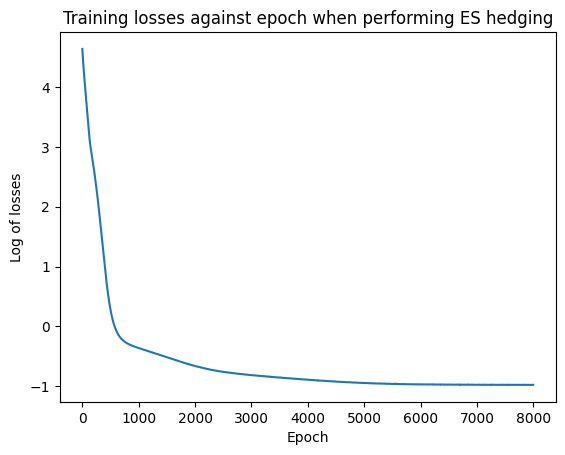

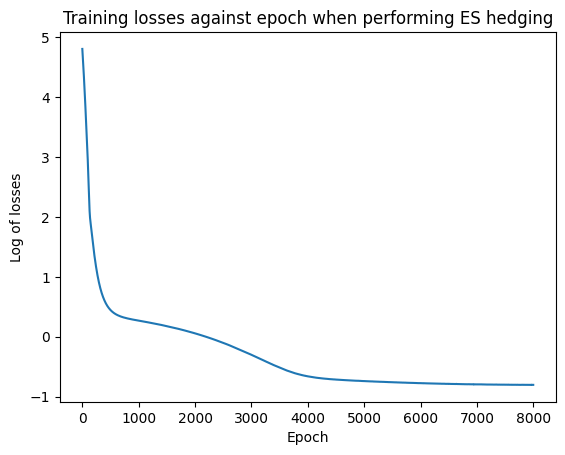

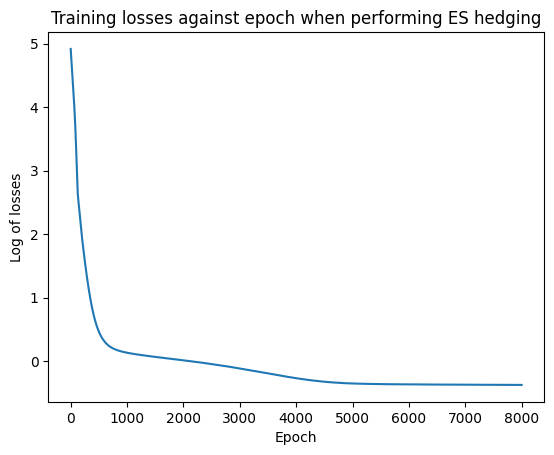

In [59]:
name_hedge = ['0_unhedge', '1_benchmark_bump',  '2_smart_bump', '3_linear_bump', 
              '4_EC', '5_PLE', '6_LS']

err_unhedge = []
err_hedge_benchmark =[]
err_hedge_smart =[]
err_hedge_linear =[]

err_hedge_EC =[]
err_hedge_PLE =[]
err_hedge_LS =[]

for i,_ in enumerate(risk_horizons):
   
    model_market_LS.fit(d_features_market_train[i], d_xi_train[i])
    model_market_PLE.fit(d_features_market_train[i], d_CVA_nn_train[i])
    
    model_market_EC.fit(d_features_market_train[i], d_CVA_nn_train[i])

    err_unhedge.append((d_CVA_nn_test[i]- d_CVA_nn_test[i].mean(), d_CVA_nn_test[i].mean()))
    err_hedge_benchmark.append(hedging_error(model_market_benchmark, d_features_market_test[i], d_CVA_nn_test[i]))
    err_hedge_smart.append(hedging_error(model_market_smart, d_features_market_test[i], d_CVA_nn_test[i]))
    err_hedge_linear.append(hedging_error(model_market_linear, d_features_market_test[i], d_CVA_nn_test[i]))
    
    err_hedge_EC.append(hedging_error(model_market_EC, d_features_market_test[i], d_CVA_nn_test[i]))
    err_hedge_PLE.append(hedging_error(model_market_PLE, d_features_market_test[i], d_CVA_nn_test[i]))
    err_hedge_LS.append(hedging_error(model_market_LS, d_features_market_test[i], d_CVA_nn_test[i]))
    

In [ ]:
CVA_hedging_run_on = pd.DataFrame(columns=['risk_horizon', 'hedge_type', 'score_type', 'score'])
for i,ts in enumerate(risk_horizons):

    for hedge_name, err_hedge in zip(name_hedge, [err_unhedge, err_hedge_benchmark, err_hedge_smart, 
                                  err_hedge_linear, err_hedge_EC, err_hedge_PLE, err_hedge_LS]):
        new_row = {'risk_horizon': ts, 'hedge_type': hedge_name, 'score_type': '0_mean', 
                                           'score': float(err_hedge[i][0].mean())}
        CVA_hedging_run_on.loc[len(CVA_hedging_run_on)] = new_row
        
        new_row = {'risk_horizon': ts, 'hedge_type': hedge_name, 'score_type': '1_std_compress_ratio', 
                                           'score': float(err_unhedge[i][0].std()/err_hedge[i][0].std())}
        CVA_hedging_run_on.loc[len(CVA_hedging_run_on)] = new_row
        
        new_row = {'risk_horizon': ts, 'hedge_type': hedge_name, 'score_type': '2_es_compress_ratio',
                   'score': float(es_score(err_unhedge[i][0], 0.95)/ es_score(err_hedge[i][0], 0.95))}
        CVA_hedging_run_on.loc[len(CVA_hedging_run_on)] = new_row
        
        new_row = {'risk_horizon': ts, 'hedge_type': hedge_name, 'score_type': '3_c',
                   'score': float(err_hedge[i][1])}
        CVA_hedging_run_on.loc[len(CVA_hedging_run_on)] = new_row
        

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also

    print(CVA_hedging_run_on.pivot_table(values = 'score', index = 'risk_horizon', columns=['score_type', 'hedge_type']).round(4))

In [ ]:
from matplotlib.ticker import LogLocator, LogFormatter


m_list = ['*', 'v', 'X', 'o', 'D', 's']
c_list = ['C0','C1','C2']*2

fig, ax = plt.subplots(1,3,figsize=(20,5),  dpi = 90)
plt.subplots_adjust(wspace=0.2)

res = CVA_hedging_run_on
for j, (name_s, score) in enumerate(zip(["Unexplained PnL\n Compression Ratio", 'Economic Capital\n Compression Ratio', 'HVA trend $c$'], 
                                        ['1_std_compress_ratio', '2_es_compress_ratio', '3_c'])):

    i = 0
    res_delta =  res[res['hedge_type'].isin(['1_benchmark_bump', '2_smart_bump', 
                                             '4_EC', '5_PLE' , '6_LS'])]

    for itt, t in enumerate([0.01,0.1,1]):

        res_sub_delta = res_delta.loc[(res_delta['risk_horizon']==t) & (res_delta['score_type']==score)]

        #if j ==0:
        #res_sub_delta = res_sub_delta.iloc[[0,1,4,3,2]]

        iddd = np.arange(len(res_sub_delta['hedge_type']))
        ax[j].plot(iddd+itt*0.05#res_sub_delta['hedge_type']
                , res_sub_delta['score'],  
                 linestyle  = '--', 
                 marker = m_list[i], c = c_list[i],
                markersize =22, label = "$t= $"+str(t), linewidth  = 3)
        ax[j].set_xticks(iddd, res_sub_delta['hedge_type'])  
        

        if j == 2:
            ax[j].axhline(y = (float(res[(res['hedge_type'] =='0_unhedge') & (res['risk_horizon'] ==t) & (res['score_type'] ==score)]['score'])),  linestyle  = '-.', c = c_list[i], lw = 3)
        i+=1
    if j<2:
        ax[j].axhline(y = 1,  linestyle  = '-.', c = 'red', lw = 3)
    xtick_name = ['bench.\nbump\nsensis', 'smart\nbump\nsensis', 'EC\nsensis', 'PLE\nsensis', 'LS\nsensis' ] #if j == 0 else ['point. \n bump sensis', 'fast bump \n sensis', 'one-shot \n LS sensis', 'LS \n sensis', 'EC \n sensis']
    #if score == '2_es':
    #    xtick_name = ['No hedge']+ xtick_name
    ax[j].set_xlabel('', fontsize = 1)  
    ax[j].set_xticklabels(xtick_name#, rotation = 45
               #res_delta['hedge_type'].unique(),
                       )  
    ax[j].set_title(name_s, fontsize = 22)  
    ax[j].xaxis.set_tick_params(labelsize=18)
    ax[j].yaxis.set_tick_params(labelsize=22)
    ax[j].grid()
    if j <2:
        ax[j].yaxis.set_major_locator(MaxNLocator(nbins = 10,integer=True))
    else:
        ax[j].set_yscale('log', base=10, )


legd = plt.legend( loc='lower center', bbox_to_anchor=(-1.64, 0.04),
fancybox=True, fontsize = 21, frameon=True, ncol=1,handletextpad=0.5, columnspacing=0.5)
#plt.savefig('sensi.pdf', #bbox_extra_artists=(legd,), 
#        bbox_inches='tight')

plt.show()
